In [1]:
import pandas as pd
import re
import math
import numpy as np
import scipy
import os
import time
import seaborn as sns
from scipy.stats import binom, hypergeom
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


%matplotlib inline

In [2]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

In [3]:
df = pd.read_csv('cab_rides.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
distance            693071 non-null float64
cab_type            693071 non-null object
time_stamp          693071 non-null int64
destination         693071 non-null object
source              693071 non-null object
price               637976 non-null float64
surge_multiplier    693071 non-null float64
id                  693071 non-null object
product_id          693071 non-null object
name                693071 non-null object
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [5]:
df.describe()

,distance,time_stamp,price,surge_multiplier
count,693071.000000,6.930710e+05,637976.000000,693071.000000
mean,2.189430,1.544046e+12,16.545125,1.013870
std,1.138937,6.891925e+08,9.324359,0.091641
min,0.020000,1.543204e+12,2.500000,1.000000
25%,1.280000,1.543444e+12,9.000000,1.000000
50%,2.160000,1.543737e+12,13.500000,1.000000
75%,2.920000,1.544828e+12,22.500000,1.000000
max,7.860000,1.545161e+12,97.500000,3.000000


In [7]:
df['day']=df.time_stamp.apply(lambda x: time.strftime('%a', time.localtime(x/1000)))


In [8]:
df['AMPM']=df.time_stamp.apply(lambda x: time.strftime('%p', time.localtime(x/1000)))


In [10]:
df['month']=df.time_stamp.apply(lambda x: time.strftime('%b', time.localtime(x/1000)))


In [13]:
df['time']=df.time_stamp.apply(lambda x: time.strftime('%H', time.localtime(x/1000)))


In [14]:
df['week']=df.time_stamp.apply(lambda x: time.strftime('%U', time.localtime(x/1000)))


In [23]:
df['date_time']=df.time_stamp.apply(lambda x: time.strftime('%Y-%m-%d %H', time.localtime(x/1000)))


In [24]:
df.date_time.max()

'2018-12-18 14'

In [25]:
df.date_time.min()

'2018-11-25 22'

In [19]:
df.week.max()

'50'

In [20]:
df.week.min()

'47'

In [26]:
df['merge_date'] = df.source.astype(str) +" - "+ df.date_time.astype("str") 



In [27]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time,day,AMPM,month,time,week,merge_date
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 04,Sun,AM,Dec,04,50,Haymarket Square - 2018-12-16 04
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-26 21,Mon,PM,Nov,21,47,Haymarket Square - 2018-11-26 21
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-27 20,Tue,PM,Nov,20,47,Haymarket Square - 2018-11-27 20
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-29 23,Thu,PM,Nov,23,47,Haymarket Square - 2018-11-29 23
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-28 22,Wed,PM,Nov,22,47,Haymarket Square - 2018-11-28 22


In [28]:
df1 = pd.read_csv('weather.csv')

In [29]:
df1.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [32]:
df1['date_time']=df1.time_stamp.apply(lambda x: time.strftime('%Y-%m-%d %H', time.localtime(x)))


In [739]:
df1.date_time.nunique()

330

In [36]:
#merge the datasets to refelect same time for a location
df1['merge_date'] = df1.location.astype(str) +" - "+ df1.date_time.astype("str") 


In [117]:
merged_df = df.merge(df1, how='inner', left_on = ['merge_date'], right_on=['merge_date'], suffixes=('_c','_w'))
merged_df.head()

,distance,cab_type,time_stamp_c,destination,source,price,surge_multiplier,id,product_id,name,...,merge_date,temp,location,clouds,pressure,rain,time_stamp_w,humidity,wind,date_time_w
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
1,1.33,Lyft,1544952309308,Beacon Hill,Haymarket Square,7.0,1.0,0d468502-34b5-447f-be9f-acbb62176072,lyft,Lyft,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
2,0.53,Lyft,1544951109578,North Station,Haymarket Square,27.5,1.0,2aa8d17e-4b13-4200-87db-db3eed73ca6b,lyft_luxsuv,Lux Black XL,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
3,2.36,Lyft,1544954108860,Back Bay,Haymarket Square,7.0,1.0,4944c164-0463-47b9-96e1-15ffe8b9c7c9,lyft_line,Shared,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
4,0.62,Uber,1544954108161,West End,Haymarket Square,10.5,1.0,b1c23003-39fb-4030-9961-4f3420b23907,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04


In [118]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1265675 entries, 0 to 1265674
Data columns (total 26 columns):
distance            1265675 non-null float64
cab_type            1265675 non-null object
time_stamp_c        1265675 non-null int64
destination         1265675 non-null object
source              1265675 non-null object
price               1164996 non-null float64
surge_multiplier    1265675 non-null float64
id                  1265675 non-null object
product_id          1265675 non-null object
name                1265675 non-null object
date_time_c         1265675 non-null object
day                 1265675 non-null object
AMPM                1265675 non-null object
month               1265675 non-null object
time                1265675 non-null object
week                1265675 non-null object
merge_date          1265675 non-null object
temp                1265675 non-null float64
location            1265675 non-null object
clouds              1265675 non-null float64
pre

In [119]:
merged_df.drop_duplicates(subset='id', keep='first', inplace=True)

In [120]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690107 entries, 0 to 1265669
Data columns (total 26 columns):
distance            690107 non-null float64
cab_type            690107 non-null object
time_stamp_c        690107 non-null int64
destination         690107 non-null object
source              690107 non-null object
price               635242 non-null float64
surge_multiplier    690107 non-null float64
id                  690107 non-null object
product_id          690107 non-null object
name                690107 non-null object
date_time_c         690107 non-null object
day                 690107 non-null object
AMPM                690107 non-null object
month               690107 non-null object
time                690107 non-null object
week                690107 non-null object
merge_date          690107 non-null object
temp                690107 non-null float64
location            690107 non-null object
clouds              690107 non-null float64
pressure            6901

In [121]:
merged_df['time'] = merged_df['time'].astype(int)


In [122]:
merged_df['rushhr'] = 0

In [123]:
merged_df.loc[(merged_df.time > 7) & (merged_df.time < 10), 'rushhr'] = 1

In [124]:
merged_df.loc[(merged_df.time > 17) & (merged_df.time < 22), 'rushhr'] = 1

In [125]:
merged_df.groupby('time')['rushhr'].sum()

time
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8     30384
9     30384
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18    31931
19    32413
20    27768
21    28548
22        0
23        0
Name: rushhr, dtype: int64

In [126]:
merged_df = pd.get_dummies(merged_df, columns=[
                           'cab_type', 'destination', 'source', 'name', 'day', 'AMPM', 'month', 'week'])

In [127]:
merged_df.head(100)

,distance,time_stamp_c,price,surge_multiplier,id,product_id,date_time_c,time,merge_date,temp,...,day_Tue,day_Wed,AMPM_AM,AMPM_PM,month_Dec,month_Nov,week_47,week_48,week_49,week_50
0,0.44,1544952607890,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,2018-12-16 04,4,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
1,1.33,1544952309308,7.0,1.0,0d468502-34b5-447f-be9f-acbb62176072,lyft,2018-12-16 04,4,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
2,0.53,1544951109578,27.5,1.0,2aa8d17e-4b13-4200-87db-db3eed73ca6b,lyft_luxsuv,2018-12-16 04,4,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
3,2.36,1544954108860,7.0,1.0,4944c164-0463-47b9-96e1-15ffe8b9c7c9,lyft_line,2018-12-16 04,4,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
4,0.62,1544954108161,10.5,1.0,b1c23003-39fb-4030-9961-4f3420b23907,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,2018-12-16 04,4,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
5,0.49,1544953210139,26.0,1.0,b2c44c57-4728-441e-83ce-f796a55e6b20,6d318bcc-22a3-4af6-bddd-b409bfce1546,2018-12-16 04,4,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
6,0.91,1544952010722,NaN,1.0,bf959122-861a-479d-804b-fdfdc83c2011,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,2018-12-16 04,4,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
7,2.38,1544950807092,16.5,1.0,e20be752-be44-4093-8600-c48608b7079e,lyft_premier,2018-12-16 04,4,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
8,0.61,1544953511805,6.5,1.0,04f35170-0dad-4ae2-b5c9-02310e811fd8,997acbb5-e102-41e1-b155-9df7de0a73f2,2018-12-16 04,4,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1
9,1.16,1544953810508,13.0,1.0,c797e710-b45d-4005-9ba6-c425ff306c05,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,2018-12-16 04,4,Haymarket Square - 2018-12-16 04,38.46,...,0,0,1,0,1,0,0,0,0,1


In [128]:
merged_df['Black'] = 0

In [129]:
merged_df['Black'] = merged_df['name_Black'] + merged_df['name_Black SUV'] + \
    merged_df['name_Lux Black'] + merged_df['name_Lux Black XL']

In [130]:
merged_df.groupby('Black')['name_Black','name_Black SUV','name_Lux Black','name_Lux Black XL'].sum()

,name_Black,name_Black SUV,name_Lux Black,name_Lux Black XL
Black,,,,
0,0.0,0.0,0.0,0.0
1,54852.0,54849.0,51021.0,51019.0


In [131]:
merged_df['sports'] = 0

In [132]:
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-02')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-11-30')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-06')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-10')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-14')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-11-29')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-01')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-08')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-11')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-16')) & (merged_df.AMPM_PM == 1), 'sports'] = 1

In [137]:
sportdf = merged_df.groupby('date_time_c')['sports'].sum()
with pd.option_context("display.max_rows", 1000):
    display(sportdf)

date_time_c
2018-11-25 22       0
2018-11-25 23       0
2018-11-26 00       0
2018-11-26 01       0
2018-11-26 02       0
2018-11-26 03       0
2018-11-26 04       0
2018-11-26 05       0
2018-11-26 06       0
2018-11-26 07       0
2018-11-26 08       0
2018-11-26 09       0
2018-11-26 10       0
2018-11-26 11       0
2018-11-26 12       0
2018-11-26 13       0
2018-11-26 14       0
2018-11-26 15       0
2018-11-26 16       0
2018-11-26 17       0
2018-11-26 18       0
2018-11-26 19       0
2018-11-26 20       0
2018-11-26 21       0
2018-11-26 22       0
2018-11-26 23       0
2018-11-27 00       0
2018-11-27 01       0
2018-11-27 02       0
2018-11-27 03       0
2018-11-27 04       0
2018-11-27 05       0
2018-11-27 06       0
2018-11-27 07       0
2018-11-27 08       0
2018-11-27 09       0
2018-11-27 10       0
2018-11-27 11       0
2018-11-27 12       0
2018-11-27 13       0
2018-11-27 14       0
2018-11-27 15       0
2018-11-27 16       0
2018-11-27 17       0
2018-11-27 18       

In [139]:
np.sum(merged_df.isnull(),axis = 0)

distance                                    0
time_stamp_c                                0
price                                   54865
surge_multiplier                            0
id                                          0
product_id                                  0
date_time_c                                 0
time                                        0
merge_date                                  0
temp                                        0
location                                    0
clouds                                      0
pressure                                    0
rain                                   591351
time_stamp_w                                0
humidity                                    0
wind                                        0
date_time_w                                 0
rushhr                                      0
cab_type_Lyft                               0
cab_type_Uber                               0
destination_Back Bay              

In [140]:
merged_df.rain.fillna(0, inplace= True)

In [141]:
merged_df['rain_d']=0

In [142]:
merged_df.loc[(merged_df.rain) > 0, 'rain_d'] = 1


In [144]:
merged_df[merged_df.rain_d == 0].count()

distance                               591351
time_stamp_c                           591351
price                                  544454
surge_multiplier                       591351
id                                     591351
product_id                             591351
date_time_c                            591351
time                                   591351
merge_date                             591351
temp                                   591351
location                               591351
clouds                                 591351
pressure                               591351
rain                                   591351
time_stamp_w                           591351
humidity                               591351
wind                                   591351
date_time_w                            591351
rushhr                                 591351
cab_type_Lyft                          591351
cab_type_Uber                          591351
destination_Back Bay              

In [176]:
merged_df['wkndPM']=0

In [177]:
merged_df.loc[(merged_df.day_Fri == 1) & (merged_df.AMPM_PM == 1), 'wkndPM'] = 1
merged_df.loc[(merged_df.day_Sat == 1) & (merged_df.AMPM_PM == 1), 'wkndPM'] = 1
merged_df.loc[(merged_df.day_Sun == 1) & (merged_df.AMPM_PM == 1), 'wkndPM'] = 1

In [179]:
wkndPMdf = merged_df.groupby('merge_date')['wkndPM'].sum()
with pd.option_context("display.max_rows", 1000):
    display(wkndPMdf)

merge_date
Back Bay - 2018-11-25 22              8
Back Bay - 2018-11-25 23             23
Back Bay - 2018-11-26 00              0
Back Bay - 2018-11-26 01              0
Back Bay - 2018-11-26 02              0
Back Bay - 2018-11-26 03              0
Back Bay - 2018-11-26 04              0
Back Bay - 2018-11-26 05              0
Back Bay - 2018-11-26 06              0
Back Bay - 2018-11-26 07              0
Back Bay - 2018-11-26 08              0
Back Bay - 2018-11-26 09              0
Back Bay - 2018-11-26 10              0
Back Bay - 2018-11-26 11              0
Back Bay - 2018-11-26 12              0
Back Bay - 2018-11-26 13              0
Back Bay - 2018-11-26 14              0
Back Bay - 2018-11-26 15              0
Back Bay - 2018-11-26 16              0
Back Bay - 2018-11-26 17              0
Back Bay - 2018-11-26 18              0
Back Bay - 2018-11-26 19              0
Back Bay - 2018-11-26 20              0
Back Bay - 2018-11-26 21              0
Back Bay - 2018-11-26 22     

In [145]:
merged_df.dropna(inplace=True)

In [156]:
merged_df.drop(['time_stamp_c', 'time_stamp_w', 'date_time_c',
                'date_time_w', 'id', 'product_id'], axis=1, inplace=True)

In [203]:
from sklearn import preprocessing

In [432]:
merged_df.columns

Index(['distance', 'price', 'surge_multiplier', 'time', 'merge_date', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'rushhr',
       'cab_type_Lyft', 'cab_type_Uber', 'destination_Back Bay',
       'destination_Beacon Hill', 'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 'source_Beacon Hill',
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black 

In [9]:
merged_df['base_price'] = merged_df.price/merged_df.surge_multiplier

In [442]:
names = ['distance', 'price', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'base_price', 'surge_multiplier']
for n in names:
    merged_df[f'n{n}'] = (merged_df[n] - merged_df[n].mean())/(merged_df[n].max() - merged_df[n].min())


In [10]:
names = ['distance', 'price', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'base_price', 'surge_multiplier']
for n in names:
    merged_df[f'l{n}'] = np.log(merged_df[n])

/Users/ptw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [444]:
merged_df.describe()

,distance,price,surge_multiplier,time,temp,clouds,pressure,rain,humidity,wind,...,lclouds,lpressure,lrain,lhumidity,lwind,base_price,nbase_price,lbase_price,nsurge_multiplier,lsurge_multiplier
count,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,...,6.352420e+05,635242.000000,6.352420e+05,635242.000000,635242.000000,635242.000000,6.352420e+05,635242.000000,6.352420e+05,635242.000000
mean,2.188876,16.544083,1.015064,11.677816,39.222256,0.667847,1010.228290,0.005623,0.747293,6.917946,...,-inf,6.917844,-inf,-0.306807,1.753753,16.257008,6.040604e-17,2.637815,-1.387745e-15,0.011891
std,1.135326,9.323372,0.095413,6.788870,6.599625,0.313867,13.383809,0.026626,0.128965,3.648678,...,NaN,0.013237,NaN,0.178236,0.658894,8.887298,1.021529e-01,0.560003,4.770634e-02,0.071604
min,0.020000,2.500000,1.000000,0.000000,19.620000,0.000000,988.250000,0.000000,0.450000,0.300000,...,-inf,6.895936,-inf,-0.798508,-1.203973,2.500000,-1.581265e-01,0.916291,-7.532169e-03,0.000000
25%,1.270000,9.000000,1.000000,6.000000,36.110000,0.430000,999.950000,0.000000,0.650000,3.630000,...,-8.439701e-01,6.907705,-inf,-0.430783,1.289233,9.000000,-8.341388e-02,2.197225,-7.532169e-03,0.000000
50%,2.160000,13.500000,1.000000,12.000000,40.180000,0.760000,1009.550000,0.000000,0.730000,6.740000,...,-2.744368e-01,6.917260,-inf,-0.314711,1.908060,13.500000,-3.168975e-02,2.602690,-7.532169e-03,0.000000
75%,2.930000,22.500000,1.000000,18.000000,43.600000,0.960000,1021.877500,0.000000,0.870000,9.880000,...,-4.082199e-02,6.929397,-inf,-0.139262,2.290513,22.500000,7.175853e-02,3.113515,-7.532169e-03,0.000000
max,7.860000,97.500000,3.000000,23.000000,55.410000,1.000000,1035.120000,0.274000,0.990000,18.180000,...,0.000000e+00,6.942273,-1.294627e+00,-0.010050,2.900322,89.500000,8.418735e-01,4.494239,9.924678e-01,1.098612


In [445]:
merged_df.drop(['lrain', 'lclouds'], axis=1, inplace=True)

In [446]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 635242 entries, 0 to 1265669
Data columns (total 90 columns):
distance                               635242 non-null float64
price                                  635242 non-null float64
surge_multiplier                       635242 non-null float64
time                                   635242 non-null int64
merge_date                             635242 non-null object
temp                                   635242 non-null float64
location                               635242 non-null object
clouds                                 635242 non-null float64
pressure                               635242 non-null float64
rain                                   635242 non-null float64
humidity                               635242 non-null float64
wind                                   635242 non-null float64
rushhr                                 635242 non-null int64
cab_type_Lyft                          635242 non-null uint8
cab_type_Uber 

In [450]:
merged_df.lsurge_multiplier.describe()

count    635242.000000
mean          0.011891
std           0.071604
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.098612
Name: lsurge_multiplier, dtype: float64

In [439]:
merged_df.to_csv('data/merged_df_Tues.csv')

## Visualization

In [440]:
merged_df.columns

Index(['distance', 'price', 'surge_multiplier', 'time', 'merge_date', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'rushhr',
       'cab_type_Lyft', 'cab_type_Uber', 'destination_Back Bay',
       'destination_Beacon Hill', 'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 'source_Beacon Hill',
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd39193d780>,
      dtype=object)

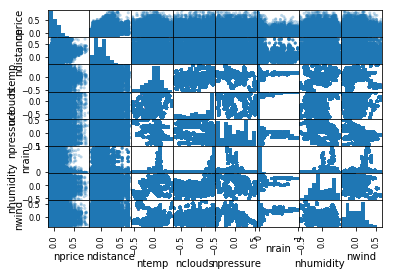

In [423]:
pd.plotting.scatter_matrix(merged_df[['lprice',
       'ldistance','lbase_price','ltemp']], alpha=.05)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9959bf4d30>,
      dtype=object)

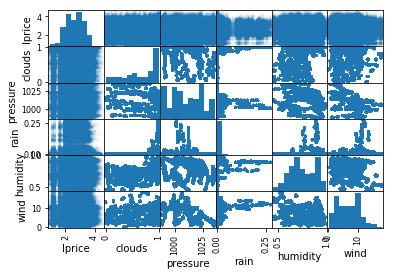

In [164]:
pd.plotting.scatter_matrix(merged_df[['lprice', 'lclouds',
       'lpressure', 'lrain', 'lhumidity', 'lwind']], alpha = .05)

In [81]:
merged_df.corr()

,distance,price,surge_multiplier,temp,clouds,pressure,rain,humidity,wind,cab_type_Lyft,...,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,name_Taxi,name_UberPool,name_UberX,name_UberXL,name_WAV
distance,1.000000,0.345082,0.025830,-0.003099,0.000342,0.003708,0.000789,-0.003740,-0.004251,-1.929998e-03,...,-0.000515,-0.000622,-0.000651,-0.000569,-0.000642,NaN,6.052217e-04,0.000524,0.000574,0.000577
price,0.345082,1.000000,0.240325,0.000005,0.001290,0.001012,0.000710,-0.001704,-0.001185,8.344084e-02,...,0.206547,0.500083,-0.219748,-0.039171,-0.333225,NaN,-2.569535e-01,-0.223527,-0.028578,-0.223570
surge_multiplier,0.025830,0.240325,1.000000,-0.001635,-0.001996,-0.002912,-0.001067,-0.001253,0.001286,1.637199e-01,...,0.068319,0.068519,0.071222,0.071166,-0.046650,NaN,-4.854270e-02,-0.048536,-0.048546,-0.048542
temp,-0.003099,0.000005,-0.001635,1.000000,0.437995,-0.377918,0.133400,0.366563,0.120664,1.926454e-03,...,-0.000582,0.001017,0.001175,0.001217,0.000318,NaN,-2.453412e-04,-0.002278,-0.001497,-0.000410
clouds,0.000342,0.001290,-0.001996,0.437995,1.000000,-0.210674,0.210941,0.509777,0.125876,-1.838530e-03,...,-0.001767,0.000983,-0.001790,0.001140,-0.000657,NaN,-9.199194e-04,0.000712,-0.000824,0.000376
pressure,0.003708,0.001012,-0.002912,-0.377918,-0.210674,1.000000,-0.069215,-0.132083,-0.569770,4.943372e-04,...,0.001093,0.001252,0.000350,-0.001506,-0.000845,NaN,1.021110e-04,0.000750,-0.000481,-0.000594
rain,0.000789,0.000710,-0.001067,0.133400,0.210941,-0.069215,1.000000,0.209892,0.218114,-3.075045e-03,...,-0.000867,-0.001492,-0.001808,-0.000359,-0.001892,NaN,1.424031e-03,0.000343,0.000167,-0.000426
humidity,-0.003740,-0.001704,-0.001253,0.366563,0.509777,-0.132083,0.209892,1.000000,-0.208435,-1.611857e-03,...,-0.000856,-0.000467,-0.001110,0.000948,-0.000815,NaN,3.347317e-04,0.000439,0.000012,0.000126
wind,-0.004251,-0.001185,0.001286,0.120664,0.125876,-0.569770,0.218114,-0.208435,1.000000,-4.234275e-03,...,-0.001954,-0.001899,-0.002297,0.000827,0.000135,NaN,1.390014e-03,0.001637,0.000142,0.000997
cab_type_Lyft,-0.001930,0.083441,0.163720,0.001926,-0.001839,0.000494,-0.003075,-0.001612,-0.004234,1.000000e+00,...,0.306438,0.306432,0.306396,0.306419,0.306386,NaN,-2.964984e-01,-0.296457,-0.296519,-0.296492


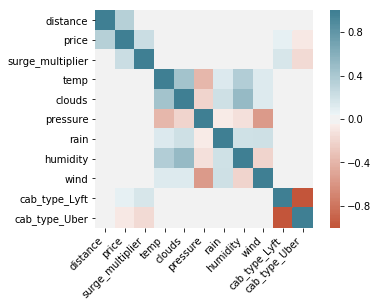

In [166]:
corr = merged_df[['distance', 'price', 'surge_multiplier', 'merge_date', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind',
       'cab_type_Lyft', 'cab_type_Uber']].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

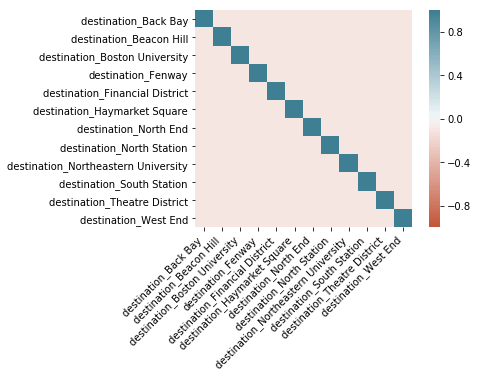

In [295]:
corr = merged_df[['destination_Back Bay',
       'destination_Beacon Hill', 'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End']].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## OLS

### Spec 1: logged numerical and all raw one hot encoded dummies minus one

In [451]:
merged_df.columns

Index(['distance', 'price', 'surge_multiplier', 'time', 'merge_date', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'rushhr',
       'cab_type_Lyft', 'cab_type_Uber', 'destination_Back Bay',
       'destination_Beacon Hill', 'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 'source_Beacon Hill',
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black 

In [469]:
X = merged_df[['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'lsurge_multiplier', 'cab_type_Uber', 'destination_Back Bay',
       'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL',
       'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_Taxi',
       'name_UberPool', 'name_UberX', 'name_UberXL', 'day_Fri',
       'day_Mon', 'day_Sat', 'day_Thu', 'day_Tue', 'day_Wed',
       'AMPM_PM', 'month_Dec', 'week_47', 'week_48',
       'week_49', 'sports', 'wkndPM']]
X = sm.add_constant(X)
Y = merged_df['lprice']

/Users/ptw/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [478]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X,Y, test_size = .2, random_state=42)

In [479]:
X_train1.shape

(508193, 57)

In [480]:
X_test1.shape

(127049, 57)

In [481]:
Y_train1.shape

(508193,)

In [482]:
Y_test1.shape

(127049,)

In [483]:
model = sm.OLS(Y_train1, X_train1).fit()

In [484]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.340e+05
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        10:07:17   Log-Likelihood:             2.5351e+05
No. Observations:              508193   AIC:                        -5.069e+05
Df Residuals:                  508139   BIC:                        -5.063e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   2.1071      0.311      6.774      0.000       1.497       2.717
ldistance                               0.3228      0.000    710.773      0.000       0.322       0.324
ltemp                                   0.0003      0.002      0.157      0.875      -0.004       0.005
clouds                                 -0.0017      0.001     -1.902      0.057      -0.003    5.13e-05
lpressure                              -0.0340      0.055     -0.622      0.534      -0.141       0.073
rain                                    0.0009      0.009      0.103      0.918      -0.017       0.018
lhumidity                              -0.0040      0.002     -1.946      0.052      -0.008    2.85e-05
lwind                                   0.0001      0.001      0.229      0.819      -0.001       0.001
lsurge_multiplier                       0.9409      0.003    318.443      0.000       0.935       0.947
cab_type_Uber                          -0.0374      0.044     -0.843      0.399      -0.125       0.050
destination_Back Bay                    0.0070      0.001      6.913      0.000       0.005       0.009
destination_Boston University           0.1823      0.026      7.029      0.000       0.131       0.233
destination_Fenway                      0.1525      0.026      5.880      0.000       0.102       0.203
destination_Financial District          0.0801      0.001     79.549      0.000       0.078       0.082
destination_Haymarket Square            0.1660      0.026      6.400      0.000       0.115       0.217
destination_North End                   0.1430      0.026      5.511      0.000       0.092       0.194
destination_North Station               0.0496      0.001     48.779      0.000       0.048       0.052
destination_Northeastern University     0.1724      0.026      6.649      0.000       0.122       0.223
destination_South Station               0.1893      0.026      7.300      0.000       0.138       0.240
destination_Theatre District            0.0272      0.001     26.862      0.000       0.025       0.029
destination_West End                    0.0237      0.001     23.367      0.000       0.022       0.026
source_Back Bay                         0.0286      0.001     28.243      0.000       0.027       0.031
source_Boston University                0.1737      0.026      6.701      0.000       0.123       0.225
source_Fenway                           0.1751      0.026      6.754      0.000       0.124       0.226
source_Financial District               0.1063      0.001    105.436      0.000       0.104       0.108
source_Haymarket Square                 0.2049      0.026      7.900      0.000       0.154       0.256
source_North End                        0.1934      0.026      7.45

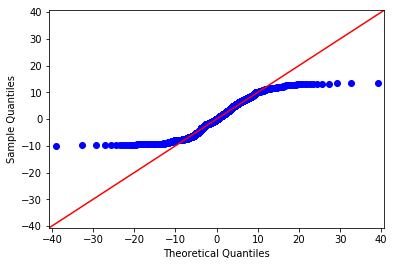

In [485]:
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line=str(45))
plt.show()

## Lasso & Ridge

In [486]:
from sklearn.linear_model import LassoCV
lasso1 = LassoCV()
lasso1.fit(X_train1, Y_train1)
preds1 = lasso1.predict(X_test)
lasso1.coef_

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 0.00000000e+00,  3.21006758e-01,  0.00000000e+00, -6.66422074e-05,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        9.18988205e-01, -4.01353343e-01,  6.20326658e-04,  8.64865228e-03,
       -1.86119489e-02,  7.37077186e-02, -6.64023187e-03, -2.93497597e-02,
        4.29953481e-02, -0.00000000e+00,  1.41758235e-02,  2.06845136e-02,
        1.71014539e-02,  1.90934467e-02, -0.00000000e+00,  0.00000000e+00,
        9.66546521e-02,  2.64235078e-02,  1.55829966e-02,  3.65465826e-02,
       -8.66900299e-03,  1.17965093e-02,  6.24361201e-02,  2.93248499e-02,
        7.39779732e-01,  1.14410430e+00,  1.47632905e-01,  4.14784108e-01,
        7.66459961e-01, -4.54797975e-01,  0.00000000e+00, -9.26354696e-01,
        0.00000000e+00, -1.09035896e-01, -8.85507704e-04,  4.59527628e-01,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.78630802e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [488]:
lasso1.score(X_test1, Y_test1)

0.9333424033441097

In [492]:
lasso1_res = Y_test1 - preds1

In [494]:
from sklearn.metrics import mean_squared_error
mse1 = mean_squared_error(Y_test1, preds1)

In [495]:
np.exp(mse1)

1.0218534684155705

In [496]:
np.exp(Y_test1).mean()

16.54675518894285

In [535]:
np.exp(mse1)/np.exp(Y_test1).mean()

0.061755519843456105

(array([1.0000e+00, 6.0000e+00, 1.1000e+01, 7.0000e+00, 4.8000e+01,
        6.0000e+01, 6.7000e+01, 1.2000e+02, 8.9000e+01, 9.3000e+01,
        2.6600e+02, 2.6000e+02, 1.8200e+02, 1.8600e+02, 5.1600e+02,
        8.4800e+02, 1.4360e+03, 4.0080e+03, 1.0697e+04, 1.5821e+04,
        2.0048e+04, 2.1033e+04, 1.8005e+04, 1.2496e+04, 8.5190e+03,
        4.9980e+03, 2.5830e+03, 1.6410e+03, 8.8000e+02, 4.9300e+02,
        4.3200e+02, 3.0400e+02, 2.6500e+02, 1.8900e+02, 1.0700e+02,
        8.7000e+01, 7.6000e+01, 4.7000e+01, 2.7000e+01, 1.6000e+01,
        1.7000e+01, 6.0000e+00, 1.4000e+01, 1.9000e+01, 4.0000e+00,
        5.0000e+00, 3.0000e+00, 9.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-1.04167955, -0.99336141, -0.94504327, -0.89672513, -0.84840699,
        -0.80008885, -0.75177071, -0.70345257, -0.65513443, -0.60681629,
        -0.55849815, -0.51018001, -0.46186187, -0.41354373, -0.36522559,
        -0.31690745, -0.26858931, -0.22027117, -0.17195303, -0.12363489,
        -0.07531675, -0.02

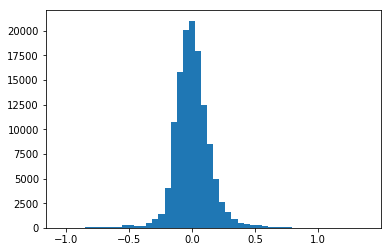

In [498]:
plt.hist(lasso1_res, bins=50)

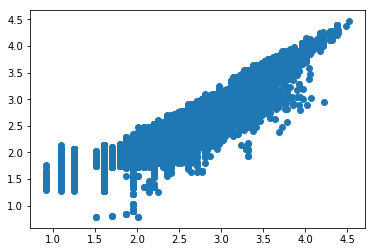

In [499]:
plt.scatter(Y_test1, preds1)

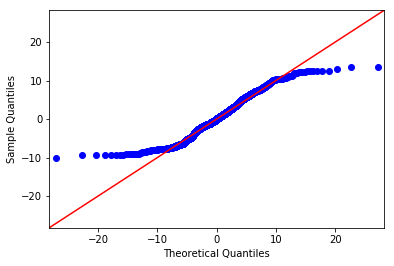

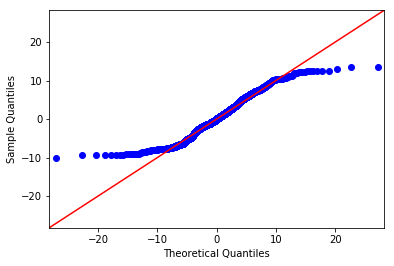

In [500]:
import scipy.stats as stats
sm.qqplot(lasso1_res, stats.t, fit=True, line=str(45))

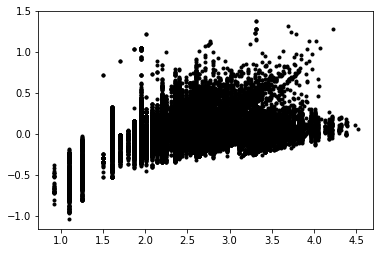

In [504]:
plt.plot(Y_test1, lasso1_res, 'k.')

In [428]:
X_train.loc[res[res > 0.15].index, :]

,const,ndistance,ntemp,nclouds,npressure,nrain,nhumidity,nwind,surge_multiplier,cab_type_Uber,...,day_Thu,day_Tue,day_Wed,AMPM_PM,month_Dec,week_47,week_48,week_49,sports,wkndPM
1015023,1.0,0.075399,0.099406,0.332153,0.102447,0.070718,0.319829,0.042620,2.00,0,...,0,0,0,0,1,0,1,0,0,0
984246,1.0,0.410858,-0.204589,-0.197847,0.224060,-0.020523,0.116125,-0.130198,1.25,0,...,0,0,0,0,1,1,0,0,0,0
439451,1.0,0.113664,0.197478,0.332153,-0.001244,-0.020523,0.356866,0.008504,1.00,1,...,0,0,0,0,1,0,1,0,0,0
540253,1.0,0.287133,0.066157,-0.197847,-0.030260,-0.020523,-0.346838,0.184679,1.75,0,...,1,0,0,1,0,1,0,0,1,0
477258,1.0,0.016725,0.040451,0.162153,-0.344320,-0.020523,-0.217209,0.129869,1.00,1,...,0,0,1,1,0,1,0,0,0,0
576871,1.0,0.292235,-0.264103,-0.467847,0.268225,-0.020523,-0.291283,-0.074270,1.00,1,...,0,0,0,1,1,0,0,1,0,1
90614,1.0,0.276929,0.067274,-0.137847,-0.133951,-0.020523,-0.217209,0.054925,1.75,0,...,0,0,0,1,1,0,1,0,0,0
1073003,1.0,0.302439,0.149979,0.332153,0.284654,-0.020523,0.227236,-0.036239,1.50,0,...,0,0,0,1,1,0,0,1,1,1
221188,1.0,0.285858,0.049672,-0.237847,0.304282,-0.020523,-0.069060,-0.040154,1.50,0,...,0,0,0,1,1,0,0,1,0,1
15499,1.0,0.109837,0.149420,0.322153,-0.414728,0.113419,0.375384,-0.047984,1.00,1,...,0,1,0,0,0,1,0,0,0,0


In [505]:
from sklearn.linear_model import RidgeCV
ridge1 = RidgeCV()
ridge1.fit(X_train1, Y_train1)
preds1r = ridge1.predict(X_test1)
ridge1.coef_

array([ 0.00000000e+00,  3.22816497e-01,  3.94115646e-04, -1.70551042e-03,
       -2.98511272e-02,  8.80919622e-04, -3.91730525e-03,  1.30647722e-04,
        9.40569090e-01, -3.38414547e-01,  6.98434774e-03,  6.72381156e-03,
       -2.30690253e-02,  8.01324647e-02, -9.57725805e-03, -3.26357552e-02,
        4.95690179e-02, -3.14534488e-03,  1.37407449e-02,  2.72450709e-02,
        2.36722629e-02,  2.86084479e-02, -1.84125451e-03, -4.41410103e-04,
        1.06247878e-01,  2.93155499e-02,  1.77951133e-02,  4.63861293e-02,
       -1.04342008e-02,  1.35690292e-02,  7.20591335e-02,  3.91472943e-02,
        7.43527246e-01,  1.14784981e+00,  2.13751894e-01,  4.80916379e-01,
        8.32597948e-01, -3.91372664e-01,  6.47952716e-02, -8.62274282e-01,
        0.00000000e+00, -1.07805027e-01,  3.38847581e-04,  4.63280027e-01,
       -4.18141919e-03, -1.16814113e-03, -2.87788459e-03, -3.88609461e-03,
       -2.37782989e-03, -4.36055009e-03, -1.08950080e-03, -3.03027652e-04,
        1.75383726e-03, -

In [506]:
ridge1.score(X_test1, Y_test1)

0.9333780463535375

In [507]:
ridge1_res = Y_test1 - preds1r

In [508]:
from sklearn.metrics import mean_squared_error
mse1r = mean_squared_error(Y_test1, preds1r)

In [510]:
np.exp(mse1r)

1.0218416562797008

In [511]:
np.exp(Y_test1).mean()

16.54675518894285

In [537]:
np.exp(mse1r)/np.exp(Y_test1).mean()

0.06175480597927339

(array([1.0000e+00, 6.0000e+00, 1.1000e+01, 6.0000e+00, 4.7000e+01,
        5.9000e+01, 5.6000e+01, 1.3000e+02, 8.9000e+01, 8.2000e+01,
        2.6700e+02, 2.6600e+02, 1.8400e+02, 1.7500e+02, 5.1600e+02,
        8.2100e+02, 1.4220e+03, 4.0570e+03, 1.0488e+04, 1.5844e+04,
        2.0284e+04, 2.0883e+04, 1.8181e+04, 1.2499e+04, 8.5050e+03,
        5.0430e+03, 2.5820e+03, 1.5520e+03, 8.6900e+02, 4.8800e+02,
        4.3900e+02, 3.0400e+02, 2.6700e+02, 1.8800e+02, 1.0800e+02,
        8.3000e+01, 7.6000e+01, 4.6000e+01, 3.2000e+01, 1.3000e+01,
        1.3000e+01, 9.0000e+00, 1.4000e+01, 1.9000e+01, 5.0000e+00,
        4.0000e+00, 3.0000e+00, 6.0000e+00, 5.0000e+00, 2.0000e+00]),
 array([-1.04513095, -0.99665875, -0.94818654, -0.89971433, -0.85124213,
        -0.80276992, -0.75429771, -0.70582551, -0.6573533 , -0.60888109,
        -0.56040889, -0.51193668, -0.46346447, -0.41499227, -0.36652006,
        -0.31804785, -0.26957565, -0.22110344, -0.17263123, -0.12415903,
        -0.07568682, -0.02

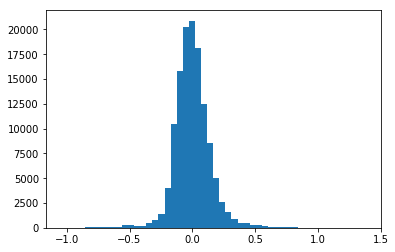

In [538]:
plt.hist(ridge1_res, bins=50)

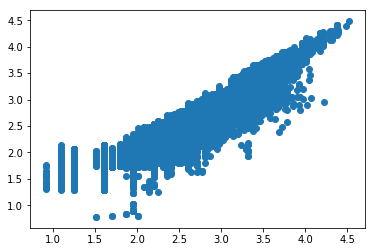

In [514]:
plt.scatter(Y_test1, preds1r)

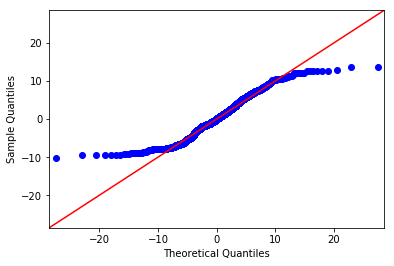

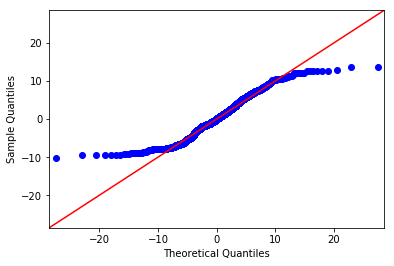

In [515]:
sm.qqplot(ridge1_res, stats.t, fit=True, line=str(45))

### Spec 2: normalized numerical and all raw one hot encoded dummies minus one and rain dummy

In [280]:
merged_df.columns

Index(['distance', 'price', 'surge_multiplier', 'time', 'merge_date', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'rushhr',
       'cab_type_Lyft', 'cab_type_Uber', 'destination_Back Bay',
       'destination_Beacon Hill', 'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 'source_Beacon Hill',
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black 

In [553]:
X2 = merged_df[['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'lsurge_multiplier', 'cab_type_Uber', 'destination_Back Bay',
       'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL',
       'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_Taxi',
       'name_UberPool', 'name_UberX', 'name_UberXL', 'day_Fri',
       'day_Mon', 'day_Sat', 'day_Thu', 'day_Tue', 'day_Wed',
       'AMPM_PM', 'month_Dec', 'week_47', 'week_48',
       'week_49', 'sports', 'wkndPM', 'rain_d']]
X2 = sm.add_constant(X2)
Y2 = merged_df['lprice']

/Users/ptw/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [554]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2,Y2, test_size = .2, random_state=42)

In [555]:
X_train2.shape

(508193, 58)

In [556]:
X_test2.shape

(127049, 58)

In [557]:
Y_train2.shape

(508193,)

In [558]:
Y_test2.shape

(127049,)

In [559]:
model2 = sm.OLS(Y_train2, X_train2).fit()

In [560]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.315e+05
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        10:23:20   Log-Likelihood:             2.5351e+05
No. Observations:              508193   AIC:                        -5.069e+05
Df Residuals:                  508138   BIC:                        -5.063e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   2.2052      0.319      6.911      0.000       1.580       2.831
ldistance                               0.3228      0.000    710.775      0.000       0.322       0.324
ltemp                                   0.0002      0.002      0.106      0.916      -0.004       0.004
clouds                                 -0.0018      0.001     -2.056      0.040      -0.004   -8.62e-05
lpressure                              -0.0513      0.056     -0.915      0.360      -0.161       0.059
rain                                   -0.0045      0.010     -0.457      0.648      -0.024       0.015
lhumidity                              -0.0046      0.002     -2.194      0.028      -0.009      -0.000
lwind                               -7.915e-05      0.001     -0.148      0.883      -0.001       0.001
lsurge_multiplier                       0.9409      0.003    318.445      0.000       0.935       0.947
cab_type_Uber                          -0.0234      0.046     -0.514      0.607      -0.113       0.066
destination_Back Bay                    0.0070      0.001      6.915      0.000       0.005       0.009
destination_Boston University           0.1905      0.027      7.160      0.000       0.138       0.243
destination_Fenway                      0.1607      0.027      6.039      0.000       0.109       0.213
destination_Financial District          0.0801      0.001     79.549      0.000       0.078       0.082
destination_Haymarket Square            0.1742      0.027      6.547      0.000       0.122       0.226
destination_North End                   0.1511      0.027      5.680      0.000       0.099       0.203
destination_North Station               0.0496      0.001     48.783      0.000       0.048       0.052
destination_Northeastern University     0.1806      0.027      6.789      0.000       0.128       0.233
destination_South Station               0.1975      0.027      7.423      0.000       0.145       0.250
destination_Theatre District            0.0273      0.001     26.866      0.000       0.025       0.029
destination_West End                    0.0237      0.001     23.372      0.000       0.022       0.026
source_Back Bay                         0.0286      0.001     28.237      0.000       0.027       0.031
source_Boston University                0.1819      0.027      6.839      0.000       0.130       0.234
source_Fenway                           0.1833      0.027      6.892      0.000       0.131       0.235
source_Financial District               0.1062      0.001    105.421      0.000       0.104       0.108
source_Haymarket Square                 0.2131      0.027      8.009      0.000       0.161       0.265
source_North End                        0.2016      0.027      7.57

In [561]:
from sklearn.linear_model import LassoCV
lasso2 = LassoCV()
lasso2.fit(X_train2, Y_train2)
preds2 = lasso2.predict(X_test2)
lasso2.coef_

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 0.00000000e+00,  3.21006758e-01,  0.00000000e+00, -6.66422074e-05,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        9.18988205e-01, -4.01353343e-01,  6.20326658e-04,  8.64865228e-03,
       -1.86119489e-02,  7.37077186e-02, -6.64023187e-03, -2.93497597e-02,
        4.29953481e-02, -0.00000000e+00,  1.41758235e-02,  2.06845136e-02,
        1.71014539e-02,  1.90934467e-02, -0.00000000e+00,  0.00000000e+00,
        9.66546521e-02,  2.64235078e-02,  1.55829966e-02,  3.65465826e-02,
       -8.66900299e-03,  1.17965093e-02,  6.24361201e-02,  2.93248499e-02,
        7.39779732e-01,  1.14410430e+00,  1.47632905e-01,  4.14784108e-01,
        7.66459961e-01, -4.54797975e-01,  0.00000000e+00, -9.26354696e-01,
        0.00000000e+00, -1.09035896e-01, -8.85507704e-04,  4.59527628e-01,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.78630802e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [562]:
lasso2.score(X_test2, Y_test2)

0.9333424033441097

In [563]:
lasso2_res = Y_test2 - preds2

In [564]:
from sklearn.metrics import mean_squared_error
mse2 = mean_squared_error(Y_test2, preds2)

In [565]:
np.exp(mse2)

1.0218534684155705

In [566]:
np.exp(Y_test2).mean()

16.54675518894285

In [567]:
np.exp(mse2)/np.exp(Y_test2).mean()

0.061755519843456105

(array([1.0000e+00, 6.0000e+00, 1.1000e+01, 7.0000e+00, 4.8000e+01,
        6.0000e+01, 6.7000e+01, 1.2000e+02, 8.9000e+01, 9.3000e+01,
        2.6600e+02, 2.6000e+02, 1.8200e+02, 1.8600e+02, 5.1600e+02,
        8.4800e+02, 1.4360e+03, 4.0080e+03, 1.0697e+04, 1.5821e+04,
        2.0048e+04, 2.1033e+04, 1.8005e+04, 1.2496e+04, 8.5190e+03,
        4.9980e+03, 2.5830e+03, 1.6410e+03, 8.8000e+02, 4.9300e+02,
        4.3200e+02, 3.0400e+02, 2.6500e+02, 1.8900e+02, 1.0700e+02,
        8.7000e+01, 7.6000e+01, 4.7000e+01, 2.7000e+01, 1.6000e+01,
        1.7000e+01, 6.0000e+00, 1.4000e+01, 1.9000e+01, 4.0000e+00,
        5.0000e+00, 3.0000e+00, 9.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-1.04167955, -0.99336141, -0.94504327, -0.89672513, -0.84840699,
        -0.80008885, -0.75177071, -0.70345257, -0.65513443, -0.60681629,
        -0.55849815, -0.51018001, -0.46186187, -0.41354373, -0.36522559,
        -0.31690745, -0.26858931, -0.22027117, -0.17195303, -0.12363489,
        -0.07531675, -0.02

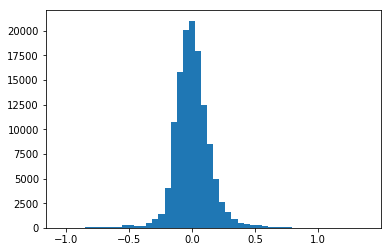

In [568]:
plt.hist(Y_test2 - preds2, bins=50)

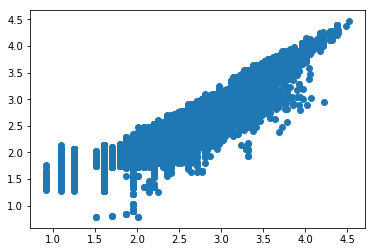

In [569]:
plt.scatter(Y_test2, preds2)

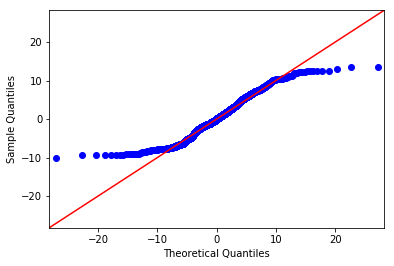

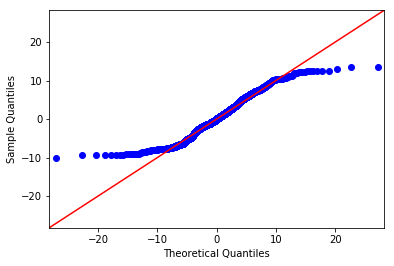

In [570]:
import scipy.stats as stats
sm.qqplot(lasso2_res, stats.t, fit=True, line=str(45))

In [571]:
from sklearn.linear_model import RidgeCV
ridge2 = RidgeCV()
ridge2.fit(X_train2, Y_train2)
preds2r = ridge2.predict(X_test2)
ridge2.coef_

array([ 0.00000000e+00,  3.22817161e-01,  3.17324716e-04, -1.85827272e-03,
       -4.47580939e-02, -4.39322575e-03, -4.48674045e-03, -5.69731679e-05,
        9.40576007e-01, -3.38413994e-01,  6.98650006e-03,  6.72397222e-03,
       -2.30632041e-02,  8.01319765e-02, -9.57378713e-03, -3.26338456e-02,
        4.95736176e-02, -3.14661547e-03,  1.37391075e-02,  2.72498052e-02,
        2.36770444e-02,  2.86027169e-02, -1.84408649e-03, -4.36487444e-04,
        1.06237144e-01,  2.93083694e-02,  1.77982316e-02,  4.63712729e-02,
       -1.04330719e-02,  1.35614176e-02,  7.20588631e-02,  3.91498571e-02,
        7.43528052e-01,  1.14784960e+00,  2.13752015e-01,  4.80916796e-01,
        8.32598210e-01, -3.91372490e-01,  6.47948193e-02, -8.62275357e-01,
        0.00000000e+00, -1.07804000e-01,  3.38091327e-04,  4.63281102e-01,
       -3.95009347e-03, -1.10662144e-03, -2.55342682e-03, -3.81508929e-03,
       -2.48922134e-03, -4.33030985e-03, -1.04398745e-03, -3.44439236e-04,
        1.53040064e-03, -

In [572]:
ridge2.score(X_test2, Y_test2)

0.9333764193251026

In [573]:
ridge2_res = Y_test2 - preds2r

In [574]:
from sklearn.metrics import mean_squared_error
mse2r = mean_squared_error(Y_test2, preds2r)

In [575]:
np.exp(mse2r)

1.021842195475892

In [576]:
np.exp(Y_test2).mean()

16.54675518894285

In [577]:
np.exp(mse2r)/np.exp(Y_test2).mean()

0.06175483856549256

(array([1.0000e+00, 6.0000e+00, 1.0000e+01, 7.0000e+00, 4.7000e+01,
        6.0000e+01, 5.4000e+01, 1.3000e+02, 9.0000e+01, 8.2000e+01,
        2.6700e+02, 2.6600e+02, 1.8400e+02, 1.7600e+02, 5.1500e+02,
        8.2100e+02, 1.4260e+03, 4.0630e+03, 1.0475e+04, 1.5845e+04,
        2.0301e+04, 2.0894e+04, 1.8167e+04, 1.2517e+04, 8.4850e+03,
        5.0340e+03, 2.5880e+03, 1.5470e+03, 8.6900e+02, 4.8800e+02,
        4.3700e+02, 3.0400e+02, 2.6700e+02, 1.8800e+02, 1.0800e+02,
        8.4000e+01, 7.4000e+01, 4.7000e+01, 3.2000e+01, 1.3000e+01,
        1.3000e+01, 9.0000e+00, 1.4000e+01, 1.9000e+01, 5.0000e+00,
        4.0000e+00, 3.0000e+00, 6.0000e+00, 5.0000e+00, 2.0000e+00]),
 array([-1.04520048, -0.99672275, -0.94824502, -0.8997673 , -0.85128957,
        -0.80281184, -0.75433412, -0.70585639, -0.65737867, -0.60890094,
        -0.56042321, -0.51194549, -0.46346776, -0.41499003, -0.36651231,
        -0.31803458, -0.26955685, -0.22107913, -0.1726014 , -0.12412367,
        -0.07564595, -0.02

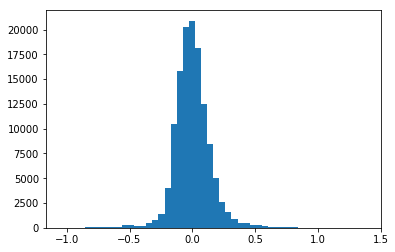

In [578]:
plt.hist(ridge2_res, bins=50)

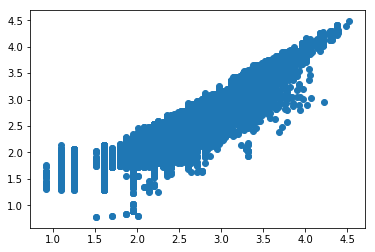

In [579]:
plt.scatter(Y_test2, preds2r)

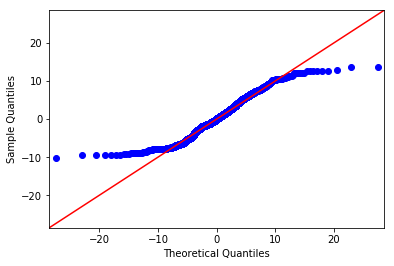

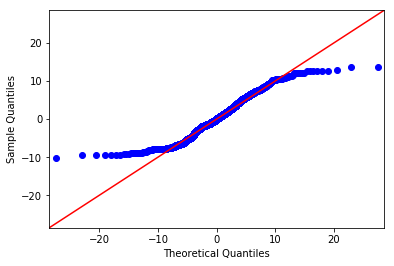

In [580]:
sm.qqplot(ridge2_res, stats.t, fit=True, line=str(45))

### Spec 3: normalized numerical and rain and selected dummies

In [280]:
merged_df.columns

Index(['distance', 'price', 'surge_multiplier', 'time', 'merge_date', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'rushhr',
       'cab_type_Lyft', 'cab_type_Uber', 'destination_Back Bay',
       'destination_Beacon Hill', 'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 'source_Beacon Hill',
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black 

In [582]:
X3 = merged_df[['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'lsurge_multiplier', 
       'cab_type_Uber', 'destination_Back Bay','source_Beacon Hill',
       'destination_Haymarket Square', 'destination_Northeastern University',
       'source_Back Bay', 'day_Fri',
       'AMPM_PM', 'month_Dec', 'sports', 'wkndPM', 'rain_d', 'Black']]
X3 = sm.add_constant(X3)
Y3 = merged_df['lprice']

/Users/ptw/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [583]:
from sklearn.model_selection import train_test_split
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3,Y3, test_size = .2, random_state=42)

In [584]:
X_train3.shape

(508193, 22)

In [585]:
X_test3.shape

(127049, 22)

In [586]:
Y_train3.shape

(508193,)

In [587]:
Y_test3.shape

(127049,)

In [588]:
model3 = sm.OLS(Y_train3, X_train3).fit()

In [589]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                 4.832e+04
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        10:26:41   Log-Likelihood:            -1.5528e+05
No. Observations:              508193   AIC:                         3.106e+05
Df Residuals:                  508171   BIC:                         3.108e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   1.9118      0.428      4.467      0.000       1.073       2.751
ldistance                               0.3121      0.001    384.194      0.000       0.310       0.314
ltemp                                   0.0037      0.003      1.138      0.255      -0.003       0.010
clouds                                 -0.0013      0.002     -0.685      0.493      -0.005       0.002
lpressure                               0.0346      0.061      0.564      0.573      -0.086       0.155
rain                                    0.0130      0.021      0.620      0.535      -0.028       0.054
lhumidity                              -0.0044      0.004     -1.200      0.230      -0.012       0.003
lwind                                  -0.0009      0.001     -0.975      0.329      -0.003       0.001
lsurge_multiplier                       1.2407      0.007    189.530      0.000       1.228       1.253
cab_type_Uber                          -0.0132      0.001    -14.131      0.000      -0.015      -0.011
destination_Back Bay                   -0.0336      0.002    -19.846      0.000      -0.037      -0.030
source_Beacon Hill                     -0.0608      0.002    -35.644      0.000      -0.064      -0.058
destination_Haymarket Square            0.0012      0.002      0.666      0.505      -0.002       0.005
destination_Northeastern University     0.0136      0.002      7.930      0.000       0.010       0.017
source_Back Bay                        -0.0360      0.002    -21.159      0.000      -0.039      -0.033
day_Fri                                -0.0029      0.002     -1.665      0.096      -0.006       0.001
AMPM_PM                                -0.0016      0.001     -1.288      0.198      -0.004       0.001
month_Dec                              -0.0014      0.001     -1.041      0.298      -0.004       0.001
sports                                  0.0009      0.002      0.452      0.652      -0.003       0.005
wkndPM                                  0.0019      0.002      0.901      0.368      -0.002       0.006
rain_d                                  0.0007      0.002      0.424      0.672      -0.003       0.004
Black                                   0.8763      0.001    896.200      0.000       0.874       0.878
==============================================================================
Omnibus:                    25233.277   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39370.791
Skew:                          -0.436   Prob(JB):                         0.00
Kurtosis:                       4.049   Cond. No.                     7.70e+03
==============================================================================

Warnings

In [590]:
from sklearn.linear_model import LassoCV
lasso3 = LassoCV()
lasso3.fit(X_train3, Y_train3)
preds3 = lasso3.predict(X_test3)
lasso3.coef_

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 0.00000000e+00,  3.11671945e-01,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -1.45908126e-04,
        1.20168222e+00, -1.34054542e-02, -3.06886970e-02, -5.71948845e-02,
        0.00000000e+00,  1.05642315e-02, -3.20043335e-02, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  8.75597434e-01])

In [591]:
lasso3.score(X_test3, Y_test3)

0.6680802411457678

In [592]:
lasso3_res = Y_test3 - preds3

In [593]:
from sklearn.metrics import mean_squared_error
mse3 = mean_squared_error(Y_test3, preds3)

In [594]:
np.exp(mse3)

1.1136543158810746

In [595]:
np.exp(Y_test3).mean()

16.54675518894285

In [596]:
np.exp(mse3)/np.exp(Y_test3).mean()

0.06730348658480542

(array([8.0000e+00, 1.3000e+01, 8.6000e+01, 1.0200e+02, 1.4900e+02,
        1.3600e+02, 2.3800e+02, 3.7900e+02, 1.6000e+02, 3.6500e+02,
        4.0900e+02, 1.9400e+02, 3.3700e+02, 4.3500e+02, 1.0120e+03,
        2.0360e+03, 1.1280e+03, 2.1910e+03, 3.5000e+03, 7.8940e+03,
        1.1436e+04, 1.2362e+04, 1.3022e+04, 8.1910e+03, 6.1970e+03,
        6.1350e+03, 8.6980e+03, 8.7130e+03, 7.5790e+03, 7.4830e+03,
        6.9110e+03, 4.8050e+03, 1.8990e+03, 1.5930e+03, 5.5500e+02,
        2.3000e+02, 1.4400e+02, 9.1000e+01, 9.0000e+01, 4.2000e+01,
        3.5000e+01, 2.4000e+01, 1.5000e+01, 6.0000e+00, 6.0000e+00,
        9.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-1.58941079, -1.52373868, -1.45806656, -1.39239444, -1.32672232,
        -1.2610502 , -1.19537809, -1.12970597, -1.06403385, -0.99836173,
        -0.93268962, -0.8670175 , -0.80134538, -0.73567326, -0.67000114,
        -0.60432903, -0.53865691, -0.47298479, -0.40731267, -0.34164056,
        -0.27596844, -0.21

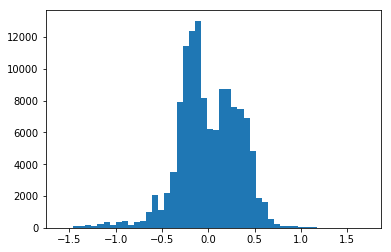

In [598]:
plt.hist(lasso3_res, bins=50)

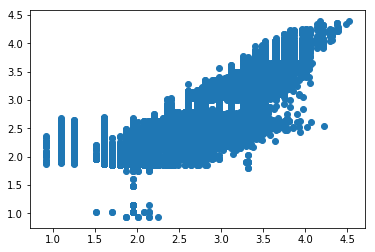

In [599]:
plt.scatter(Y_test3, preds3)

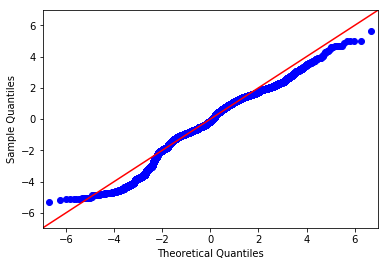

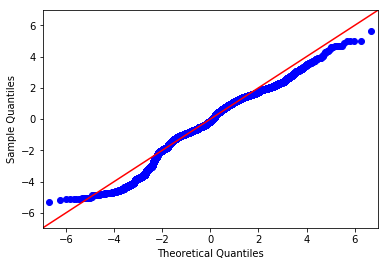

In [600]:
import scipy.stats as stats
sm.qqplot(lasso3_res, stats.t, fit=True, line=str(45))

In [607]:
from sklearn.linear_model import RidgeCV
ridge3 = RidgeCV()
ridge3.fit(X_train3, Y_train3)
preds3r = ridge3.predict(X_test3)
ridge3.coef_

array([ 0.00000000e+00,  3.12067041e-01,  3.70675007e-03, -1.29146313e-03,
        3.34274900e-02,  1.30355274e-02, -4.41817684e-03, -9.52522934e-04,
        1.24016261e+00, -1.32406881e-02, -3.35837436e-02, -6.08440523e-02,
        1.16028663e-03,  1.35500956e-02, -3.59572201e-02, -2.86429665e-03,
       -1.63899708e-03, -1.35962165e-03,  8.62948538e-04,  1.86735574e-03,
        7.29782043e-04,  8.76339861e-01])

In [608]:
ridge3.score(X_test3, Y_test3)

0.6680963314487726

In [609]:
ridge3_res = Y_test3 - preds3r

In [610]:
from sklearn.metrics import mean_squared_error
mse3r = mean_squared_error(Y_test3, preds3r)

In [611]:
np.exp(mse3r)

1.1136485044719757

In [612]:
np.exp(Y_test3).mean()

16.54675518894285

In [613]:
np.exp(mse3r)/np.exp(Y_test3).mean()

0.0673031353734028

(array([7.0000e+00, 1.3000e+01, 8.0000e+01, 1.0800e+02, 1.4300e+02,
        1.3400e+02, 2.1200e+02, 3.8700e+02, 1.6700e+02, 3.5800e+02,
        4.3100e+02, 1.9400e+02, 3.3100e+02, 4.4400e+02, 9.7200e+02,
        2.0240e+03, 1.1640e+03, 2.1870e+03, 3.4960e+03, 7.7020e+03,
        1.1345e+04, 1.2330e+04, 1.3172e+04, 8.2790e+03, 6.2080e+03,
        6.1630e+03, 8.6600e+03, 8.7880e+03, 7.6700e+03, 7.3220e+03,
        6.9730e+03, 4.8280e+03, 1.8880e+03, 1.5980e+03, 5.6200e+02,
        2.3800e+02, 1.4400e+02, 9.4000e+01, 8.8000e+01, 4.5000e+01,
        3.3000e+01, 2.5000e+01, 1.5000e+01, 6.0000e+00, 6.0000e+00,
        9.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-1.59297832, -1.5272008 , -1.46142328, -1.39564575, -1.32986823,
        -1.26409071, -1.19831319, -1.13253567, -1.06675815, -1.00098062,
        -0.9352031 , -0.86942558, -0.80364806, -0.73787054, -0.67209302,
        -0.60631549, -0.54053797, -0.47476045, -0.40898293, -0.34320541,
        -0.27742789, -0.21

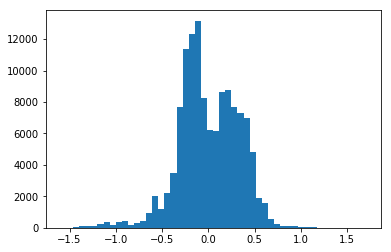

In [614]:
plt.hist(ridge3_res, bins=50)

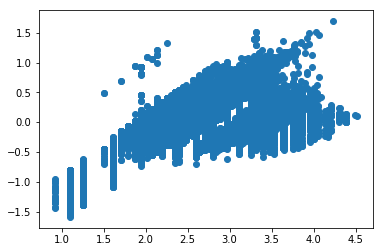

In [615]:
plt.scatter(Y_test3, ridge3_res)

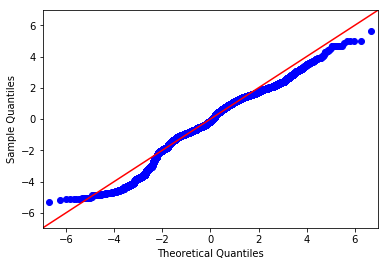

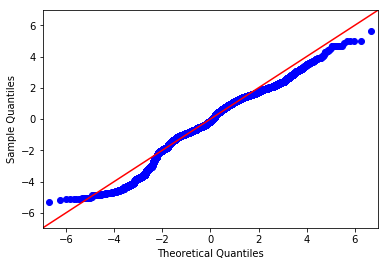

In [616]:
sm.qqplot(ridge3_res, stats.t, fit=True, line=str(45))

### Spec 4: split black and not black

In [621]:
X4 = merged_df[(merged_df.Black == 0)][['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'lsurge_multiplier', 
       'cab_type_Uber', 'destination_Back Bay','source_Beacon Hill',
       'destination_Haymarket Square', 'destination_Northeastern University',
       'source_Back Bay', 'day_Fri',
       'AMPM_PM', 'month_Dec', 'sports', 'wkndPM', 'rain_d']]
X4 = sm.add_constant(X4)
Y4 = merged_df[(merged_df.Black == 0)]['lprice']

In [622]:
from sklearn.model_selection import train_test_split
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4,Y4, test_size = .2, random_state=42)

In [623]:
X_train4.shape

(338800, 21)

In [624]:
X_test4.shape

(84701, 21)

In [625]:
Y_train4.shape

(338800,)

In [626]:
Y_test4.shape

(84701,)

In [627]:
model4 = sm.OLS(Y_train4, X_train4).fit()

In [628]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     6099.
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        10:36:32   Log-Likelihood:            -1.4397e+05
No. Observations:              338800   AIC:                         2.880e+05
Df Residuals:                  338779   BIC:                         2.882e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   1.9081      0.591      3.228      0.001       0.750       3.067
ldistance                               0.3352      0.001    298.987      0.000       0.333       0.337
ltemp                                   0.0081      0.005      1.786      0.074      -0.001       0.017
clouds                                 -0.0011      0.003     -0.427      0.669      -0.006       0.004
lpressure                               0.0290      0.085      0.342      0.732      -0.137       0.195
rain                                    0.0306      0.029      1.051      0.293      -0.026       0.088
lhumidity                              -0.0071      0.005     -1.395      0.163      -0.017       0.003
lwind                                  -0.0015      0.001     -1.117      0.264      -0.004       0.001
lsurge_multiplier                       1.3976      0.009    148.178      0.000       1.379       1.416
cab_type_Uber                           0.0040      0.001      3.116      0.002       0.001       0.007
destination_Back Bay                   -0.0258      0.002    -11.046      0.000      -0.030      -0.021
source_Beacon Hill                     -0.0505      0.002    -21.483      0.000      -0.055      -0.046
destination_Haymarket Square            0.0002      0.002      0.074      0.941      -0.005       0.005
destination_Northeastern University     0.0191      0.002      8.089      0.000       0.014       0.024
source_Back Bay                        -0.0277      0.002    -11.814      0.000      -0.032      -0.023
day_Fri                                -0.0028      0.002     -1.183      0.237      -0.007       0.002
AMPM_PM                                -0.0026      0.002     -1.507      0.132      -0.006       0.001
month_Dec                              -0.0022      0.002     -1.184      0.236      -0.006       0.001
sports                                 -0.0002      0.003     -0.094      0.925      -0.005       0.005
wkndPM                                  0.0028      0.003      0.977      0.329      -0.003       0.008
rain_d                                 -0.0004      0.002     -0.162      0.871      -0.005       0.004
==============================================================================
Omnibus:                    12328.335   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14494.888
Skew:                          -0.440   Prob(JB):                         0.00
Kurtosis:                       3.501   Cond. No.                     7.70e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The co

In [629]:
from sklearn.linear_model import LassoCV
lasso4 = LassoCV()
lasso4.fit(X_train4, Y_train4)
preds4 = lasso4.predict(X_test4)
lasso4.coef_

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 0.00000000e+00,  3.34988413e-01,  8.10948233e-04, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -5.87287842e-04,
        1.37071144e+00,  2.94674909e-03, -2.40134453e-02, -4.84241125e-02,
       -0.00000000e+00,  1.73267044e-02, -2.53561232e-02, -3.61187228e-04,
       -0.00000000e+00, -6.69170032e-04,  0.00000000e+00,  1.96998993e-04,
        0.00000000e+00])

In [631]:
lasso4.score(X_test4, Y_test4)

0.2638662955719956

In [632]:
lasso4_res = Y_test4 - preds4

In [633]:
from sklearn.metrics import mean_squared_error
mse4 = mean_squared_error(Y_test4, preds4)

In [635]:
np.exp(mse4)

1.1459486819965348

In [636]:
np.exp(Y_test4).mean()

11.526081156066635

In [637]:
np.exp(mse4)/np.exp(Y_test4).mean()

0.09942222915837934

(array([8.000e+00, 1.200e+01, 6.700e+01, 8.700e+01, 1.000e+02, 1.760e+02,
        9.900e+01, 3.260e+02, 3.580e+02, 2.470e+02, 4.200e+02, 2.470e+02,
        2.870e+02, 4.430e+02, 6.060e+02, 1.900e+03, 1.590e+03, 1.863e+03,
        2.246e+03, 3.644e+03, 6.589e+03, 9.335e+03, 8.226e+03, 5.749e+03,
        4.283e+03, 2.542e+03, 2.350e+03, 3.489e+03, 5.286e+03, 6.148e+03,
        6.384e+03, 4.992e+03, 1.798e+03, 1.571e+03, 5.670e+02, 2.430e+02,
        1.360e+02, 9.700e+01, 5.500e+01, 6.000e+01, 3.100e+01, 2.000e+01,
        1.800e+01, 1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-1.61049871, -1.54439185, -1.47828498, -1.41217812, -1.34607125,
        -1.27996438, -1.21385752, -1.14775065, -1.08164379, -1.01553692,
        -0.94943006, -0.88332319, -0.81721633, -0.75110946, -0.6850026 ,
        -0.61889573, -0.55278887, -0.486682  , -0.42057514, -0.35446827,
        -0.28836141, -0.22225454, -0.15614767, -0.09004081, -0.02393394,
         0.

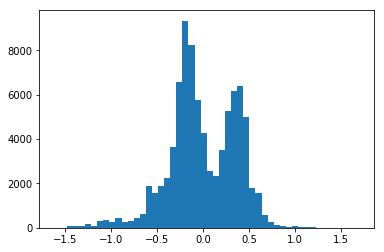

In [638]:
plt.hist(lasso4_res, bins=50)

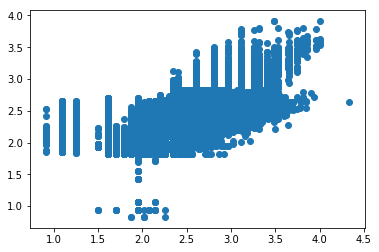

In [639]:
plt.scatter(Y_test4, preds4)

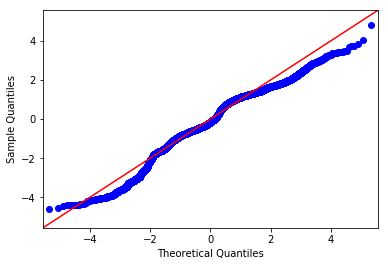

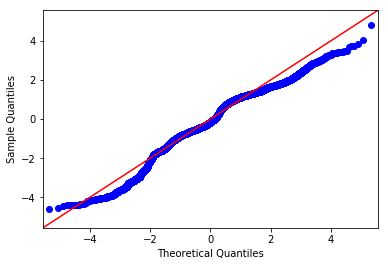

In [640]:
import scipy.stats as stats
sm.qqplot(lasso4_res, stats.t, fit=True, line=str(45))

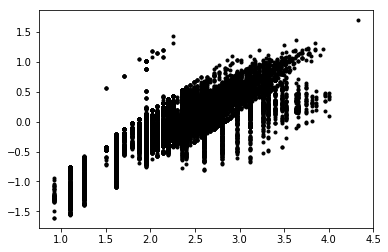

In [642]:
plt.plot(Y_test4, lasso4_res, 'k.')

In [643]:
from sklearn.linear_model import RidgeCV
ridge4 = RidgeCV()
ridge4.fit(X_train4, Y_train4)
preds4r = ridge4.predict(X_test4)
ridge4.coef_

array([ 0.00000000e+00,  3.35188331e-01,  8.03985270e-03, -1.11216184e-03,
        2.75884585e-02,  3.04695737e-02, -7.08704250e-03, -1.50289529e-03,
        1.39666645e+00,  3.99948004e-03, -2.58075816e-02, -5.05220510e-02,
        1.77226838e-04,  1.90596983e-02, -2.76651870e-02, -2.80654077e-03,
       -2.64529412e-03, -2.14062297e-03, -2.47992747e-04,  2.79218642e-03,
       -3.71447151e-04])

In [644]:
ridge4.score(X_test4, Y_test4)

0.26381726851132226

In [645]:
ridge_res4 = Y_test4 - preds4r

In [646]:
from sklearn.metrics import mean_squared_error
mse4r = mean_squared_error(Y_test4, preds4r)

In [647]:
np.exp(mse4r)

1.1459590794765673

In [649]:
np.exp(Y_test4).mean()

11.526081156066635

In [650]:
np.exp(mse4r)/np.exp(Y_test4).mean()

0.09942313124122013

(array([8.000e+00, 1.200e+01, 6.500e+01, 8.900e+01, 9.600e+01, 1.770e+02,
        9.300e+01, 3.260e+02, 3.670e+02, 2.430e+02, 4.140e+02, 2.540e+02,
        2.830e+02, 4.510e+02, 5.650e+02, 1.912e+03, 1.597e+03, 1.855e+03,
        2.270e+03, 3.587e+03, 6.661e+03, 9.307e+03, 8.236e+03, 5.747e+03,
        4.330e+03, 2.511e+03, 2.353e+03, 3.499e+03, 5.296e+03, 6.048e+03,
        6.380e+03, 5.052e+03, 1.798e+03, 1.560e+03, 5.910e+02, 2.400e+02,
        1.380e+02, 1.000e+02, 5.300e+01, 6.200e+01, 3.100e+01, 2.000e+01,
        1.800e+01, 1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-1.61124367, -1.54511784, -1.47899201, -1.41286618, -1.34674035,
        -1.28061452, -1.21448869, -1.14836286, -1.08223703, -1.0161112 ,
        -0.94998537, -0.88385954, -0.81773371, -0.75160788, -0.68548205,
        -0.61935622, -0.55323039, -0.48710456, -0.42097873, -0.3548529 ,
        -0.28872707, -0.22260124, -0.15647541, -0.09034958, -0.02422375,
         0.

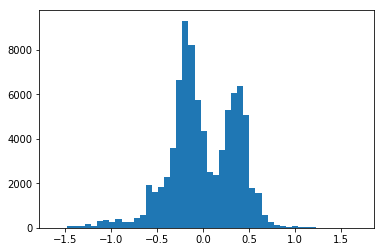

In [651]:
plt.hist(ridge_res4, bins=50)

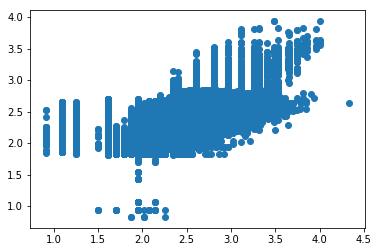

In [652]:
plt.scatter(Y_test4, preds4r)

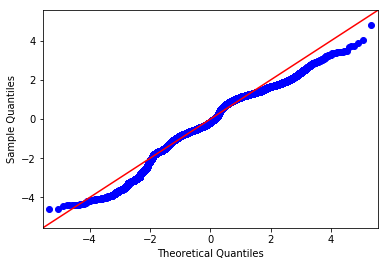

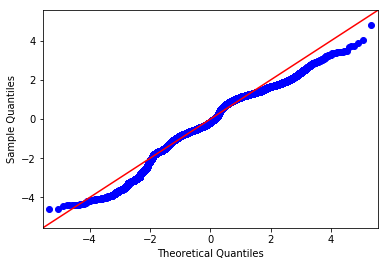

In [654]:
sm.qqplot(ridge_res4, stats.t, fit=True, line=str(45))

## Black

In [655]:
X4b = merged_df[(merged_df.Black == 1)][['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'lsurge_multiplier', 
       'cab_type_Uber', 'destination_Back Bay','source_Beacon Hill',
       'destination_Haymarket Square', 'destination_Northeastern University',
       'source_Back Bay', 'day_Fri',
       'AMPM_PM', 'month_Dec', 'sports', 'wkndPM', 'rain_d']]
X4b = sm.add_constant(X4b)
Y4b = merged_df[(merged_df.Black == 1)]['lprice']

/Users/ptw/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [656]:
from sklearn.model_selection import train_test_split
X_train4b, X_test4b, Y_train4b, Y_test4b = train_test_split(X4b,Y4b, test_size = .2, random_state=42)

In [657]:
X_train4b.shape

(169392, 21)

In [658]:
X_test4b.shape

(42349, 21)

In [659]:
Y_train4b.shape

(169392,)

In [660]:
Y_test4b.shape

(42349,)

In [661]:
model4b = sm.OLS(Y_train4b, X_train4b).fit()

In [662]:
model4b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     5874.
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        10:45:40   Log-Likelihood:                 17400.
No. Observations:              169392   AIC:                        -3.476e+04
Df Residuals:                  169371   BIC:                        -3.455e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   2.8689      0.493      5.823      0.000       1.903       3.835
ldistance                               0.2666      0.001    285.085      0.000       0.265       0.268
ltemp                                   0.0059      0.004      1.568      0.117      -0.001       0.013
clouds                                  0.0021      0.002      0.968      0.333      -0.002       0.006
lpressure                               0.0290      0.071      0.411      0.681      -0.109       0.167
rain                                   -0.0129      0.024     -0.532      0.595      -0.060       0.035
lhumidity                              -0.0052      0.004     -1.221      0.222      -0.013       0.003
lwind                                   0.0003      0.001      0.294      0.769      -0.002       0.003
lsurge_multiplier                       0.9886      0.007    140.435      0.000       0.975       1.002
cab_type_Uber                          -0.0478      0.001    -44.174      0.000      -0.050      -0.046
destination_Back Bay                   -0.0511      0.002    -26.221      0.000      -0.055      -0.047
source_Beacon Hill                     -0.0797      0.002    -40.553      0.000      -0.084      -0.076
destination_Haymarket Square            0.0001      0.002      0.062      0.951      -0.004       0.004
destination_Northeastern University     0.0099      0.002      5.021      0.000       0.006       0.014
source_Back Bay                        -0.0556      0.002    -28.335      0.000      -0.059      -0.052
day_Fri                              5.912e-05      0.002      0.030      0.976      -0.004       0.004
AMPM_PM                                -0.0010      0.001     -0.673      0.501      -0.004       0.002
month_Dec                              -0.0007      0.002     -0.491      0.624      -0.004       0.002
sports                                 -0.0025      0.002     -1.126      0.260      -0.007       0.002
wkndPM                                  0.0028      0.002      1.158      0.247      -0.002       0.007
rain_d                                  0.0007      0.002      0.357      0.721      -0.003       0.005
==============================================================================
Omnibus:                    14736.379   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4578.252
Skew:                           0.017   Prob(JB):                         0.00
Kurtosis:                       2.195   Cond. No.                     7.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The co

In [663]:
from sklearn.linear_model import LassoCV
lasso4b = LassoCV()
lasso4b.fit(X_train4b, Y_train4b)
preds4b = lasso4b.predict(X_test4b)
lasso4b.coef_

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 0.00000000e+00,  2.66474224e-01,  1.49070030e-03,  6.27015939e-04,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  3.07250258e-04,
        9.72327716e-01, -4.78822576e-02, -4.96790348e-02, -7.79850519e-02,
       -0.00000000e+00,  8.50393848e-03, -5.36869679e-02, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  2.05005159e-04,
        0.00000000e+00])

In [664]:
lasso4b.score(X_test4b, Y_test4b)

0.4137926770624586

In [665]:
lasso4b_res = Y_test4b - preds4b

In [666]:
from sklearn.metrics import mean_squared_error
mse4b = mean_squared_error(Y_test4b, preds4b)

In [667]:
np.exp(mse4b)

1.0489308472197338

In [668]:
np.exp(Y_test4b).mean()

26.518099600935088

In [669]:
np.exp(mse4b)/np.exp(Y_test4b).mean()

0.039555279714793216

(array([3.000e+01, 8.900e+01, 4.900e+02, 1.078e+03, 1.833e+03, 2.089e+03,
        2.309e+03, 1.980e+03, 2.346e+03, 2.651e+03, 2.100e+03, 1.606e+03,
        8.950e+02, 9.820e+02, 1.274e+03, 1.794e+03, 2.690e+03, 3.519e+03,
        3.326e+03, 3.149e+03, 2.432e+03, 1.160e+03, 8.780e+02, 6.080e+02,
        4.520e+02, 2.960e+02, 1.380e+02, 4.900e+01, 4.400e+01, 7.000e+00,
        1.000e+01, 4.000e+00, 4.000e+00, 8.000e+00, 3.000e+00, 3.000e+00,
        4.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 2.000e+00]),
 array([-0.4899039 , -0.45388327, -0.41786263, -0.381842  , -0.34582137,
        -0.30980074, -0.2737801 , -0.23775947, -0.20173884, -0.1657182 ,
        -0.12969757, -0.09367694, -0.0576563 , -0.02163567,  0.01438496,
         0.0504056 ,  0.08642623,  0.12244686,  0.15846749,  0.19448813,
         0.23050876,  0.26652939,  0.30255003,  0.33857066,  0.37459129,
         0.

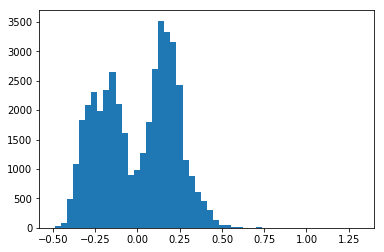

In [670]:
plt.hist(lasso4b_res, bins=50)

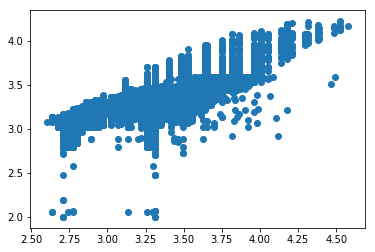

In [671]:
plt.scatter(Y_test4b, preds4b)

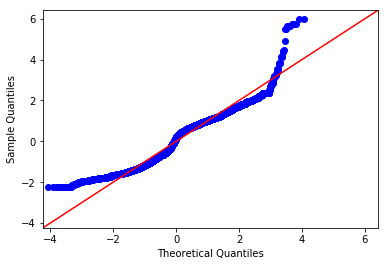

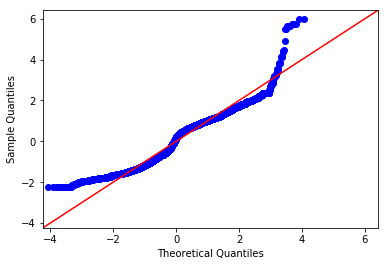

In [672]:
import scipy.stats as stats
sm.qqplot(lasso4b_res, stats.t, fit=True, line=str(45))

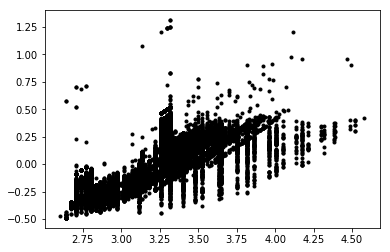

In [673]:
plt.plot(Y_test4b, lasso4b_res, 'k.')

In [674]:
from sklearn.linear_model import RidgeCV
ridge4b = RidgeCV()
ridge4b.fit(X_train4b, Y_train4b)
preds4br = ridge4.predict(X_test4b)
ridge4b.coef_

array([ 0.00000000e+00,  2.66623019e-01,  5.86039657e-03,  2.09362466e-03,
        2.61679026e-02, -1.25807227e-02, -5.20200772e-03,  3.07250501e-04,
        9.87605275e-01, -4.78061491e-02, -5.11018229e-02, -7.96724058e-02,
        1.22149448e-04,  9.91493915e-03, -5.55327123e-02,  8.70057166e-05,
       -9.86916284e-04, -7.10990122e-04, -2.48165060e-03,  2.77069003e-03,
        7.06494999e-04])

In [675]:
ridge4b.score(X_test4b, Y_test4b)

0.4137735228909599

In [676]:
ridge_res4b = Y_test4b - preds4br

In [677]:
from sklearn.metrics import mean_squared_error
mse4br = mean_squared_error(Y_test4b, preds4br)

In [678]:
np.exp(mse4br)

2.265044188371079

In [679]:
np.exp(Y_test4b).mean()

26.518099600935088

In [680]:
np.exp(mse4br)/np.exp(Y_test4b).mean()

0.08541502681026239

(array([1.000e+01, 2.200e+01, 4.400e+01, 7.800e+01, 3.270e+02, 8.860e+02,
        1.366e+03, 2.658e+03, 3.208e+03, 2.941e+03, 2.493e+03, 2.790e+03,
        2.104e+03, 1.668e+03, 1.633e+03, 2.522e+03, 3.391e+03, 3.875e+03,
        3.393e+03, 2.953e+03, 1.503e+03, 4.590e+02, 3.290e+02, 5.240e+02,
        4.940e+02, 3.410e+02, 1.640e+02, 1.140e+02, 9.000e+00, 6.000e+00,
        6.000e+00, 5.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
        6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 7.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.2455137 , 0.29033249, 0.33515129, 0.37997009, 0.42478889,
        0.46960769, 0.51442648, 0.55924528, 0.60406408, 0.64888288,
        0.69370168, 0.73852048, 0.78333927, 0.82815807, 0.87297687,
        0.91779567, 0.96261447, 1.00743326, 1.05225206, 1.09707086,
        1.14188966, 1.18670846, 1.23152725, 1.27634605, 1.32116485,
        1.36598365, 1.41080245, 1.45

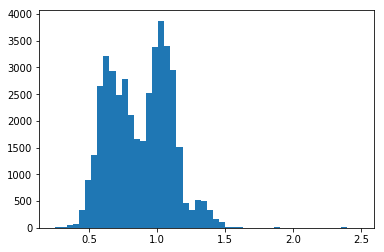

In [681]:
plt.hist(ridge_res4b, bins=50)

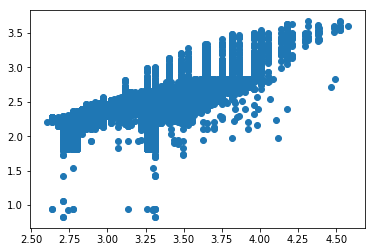

In [682]:
plt.scatter(Y_test4b, preds4br)

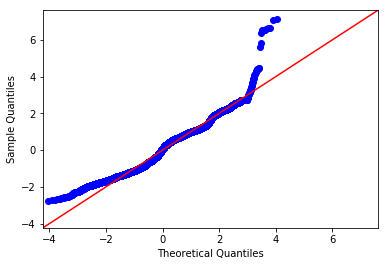

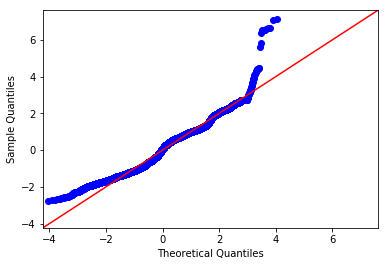

In [683]:
sm.qqplot(ridge_res4b, stats.t, fit=True, line=str(45))

## Notes

In [178]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
embeded_lr_selector = SelectFromModel(LassoCV(), max_features=20)
embeded_lr_selector.fit(X_train, Y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


20 selected features


In [179]:
embeded_lr_feature

['surge_multiplier',
 'destination_Beacon Hill',
 'destination_Financial District',
 'destination_North End',
 'destination_North Station',
 'source_Beacon Hill',
 'source_Financial District',
 'source_Theatre District',
 'name_Black',
 'name_Black SUV',
 'name_Lux',
 'name_Lux Black',
 'name_Lux Black XL',
 'name_Lyft',
 'name_Shared',
 'name_UberPool',
 'name_UberX',
 'name_UberXL',
 'name_WAV',
 'ldistance']

In [376]:
dataSet_df = merged_df[['distance', 'surge_multiplier', 'temp', 'clouds', 'pressure', 
                        'rain', 'humidity', 'wind', 'name_Black', 'name_Black SUV', 
                        'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 
                        'name_Lyft XL', 'name_Shared', 'name_Taxi', 'name_UberPool', 'name_UberX', 
                        'name_UberXL', 'name_WAV', 'destination_Back Bay', 'destination_Beacon Hill', 
                        'destination_Boston University', 'destination_Fenway', 'destination_Financial District',
                        'destination_Haymarket Square', 'destination_North End', 'destination_North Station', 
                        'destination_Northeastern University', 'destination_South Station', 
                        'destination_Theatre District', 'destination_West End', 'source_Back Bay', 
                        'source_Beacon Hill', 'source_Boston University', 'source_Fenway',
                        'source_Financial District', 'source_Haymarket Square',
                        'source_North End', 'source_North Station',
                        'source_Northeastern University', 'source_South Station',
                         'source_Theatre District', 'source_West End','price']]

In [377]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [378]:
XX= dataSet_df[['distance', 'surge_multiplier', 'temp', 'clouds', 'pressure', 
                        'rain', 'humidity', 'wind', 'name_Black', 'name_Black SUV', 
                        'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 
                        'name_Lyft XL', 'name_Shared', 'name_Taxi', 'name_UberPool', 'name_UberX', 
                        'name_UberXL', 'name_WAV', 'destination_Back Bay', 'destination_Beacon Hill', 
                        'destination_Boston University', 'destination_Fenway', 'destination_Financial District',
                        'destination_Haymarket Square', 'destination_North End', 'destination_North Station', 
                        'destination_Northeastern University', 'destination_South Station', 
                        'destination_Theatre District', 'destination_West End', 'source_Back Bay', 
                        'source_Beacon Hill', 'source_Boston University', 'source_Fenway',
                        'source_Financial District', 'source_Haymarket Square',
                        'source_North End', 'source_North Station',
                        'source_Northeastern University', 'source_South Station',
                         'source_Theatre District', 'source_West End']]
YY = dataSet_df['price']

In [379]:
X_train, X_test, y_train, y_test = train_test_split(XX.values, YY.values, test_size=0.33, random_state=42)

In [380]:
y_train.shape

(402552,)

In [381]:
regr = RandomForestRegressor(max_depth=4, random_state=137, n_estimators=1000)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=137, verbose=0, warm_start=False)

In [382]:
y_rf = regr.predict(X_test)

In [387]:
fimpDict = {}
for fimp in list(zip(XX.columns, regr.feature_importances_)):
    print(fimp)
    fimpDict.update({fimp[0]:fimp[1]})

('distance', 0.05951465433242029)
('surge_multiplier', 0.0025734811712555925)
('temp', 0.0)
('clouds', 0.0)
('pressure', 0.0)
('rain', 0.0)
('humidity', 0.0)
('wind', 0.0)
('name_Black', 0.1128144317338077)
('name_Black SUV', 0.33530052147261763)
('name_Lux', 0.0)
('name_Lux Black', 0.13720841559892896)
('name_Lux Black XL', 0.35236411865261175)
('name_Lyft', 0.0)
('name_Lyft XL', 0.0)
('name_Shared', 0.0)
('name_Taxi', 0.0)
('name_UberPool', 0.0)
('name_UberX', 0.0)
('name_UberXL', 0.0)
('name_WAV', 0.0)
('destination_Back Bay', 2.6610882907826793e-05)
('destination_Beacon Hill', 0.0)
('destination_Boston University', 0.0)
('destination_Fenway', 0.0)
('destination_Financial District', 0.0)
('destination_Haymarket Square', 2.962013986479391e-05)
('destination_North End', 0.0)
('destination_North Station', 0.0)
('destination_Northeastern University', 2.7743108181722483e-06)
('destination_South Station', 0.0)
('destination_Theatre District', 0.0)
('destination_West End', 0.0)
('source_Ba

In [405]:
kk = list(fimpDict.keys())
vv = list(fimpDict.values())


fimpDF = pd.DataFrame({'features':kk,
                      'importance':vv})









In [407]:
fimpDF.sort_values(by='importance')

,features,importance
22,destination_Beacon Hill,0.000000
23,destination_Boston University,0.000000
24,destination_Fenway,0.000000
25,destination_Financial District,0.000000
27,destination_North End,0.000000
28,destination_North Station,0.000000
30,destination_South Station,0.000000
31,destination_Theatre District,0.000000
43,source_Theatre District,0.000000
32,destination_West End,0.000000


(array([6.0000e+01, 9.8800e+02, 3.8780e+03, 1.7845e+04, 1.5703e+04,
        7.4790e+03, 1.9535e+04, 1.0448e+04, 1.8532e+04, 1.8007e+04,
        1.0067e+04, 9.6680e+03, 1.6330e+04, 5.4980e+03, 4.9110e+03,
        3.7770e+03, 2.5430e+03, 1.1524e+04, 2.2510e+03, 1.9830e+03,
        1.0200e+03, 5.8430e+03, 8.7200e+02, 3.9300e+02, 6.4000e+02,
        4.0950e+03, 4.2000e+02, 5.9100e+02, 7.8000e+01, 2.7500e+02,
        9.7400e+02, 9.4000e+01, 8.8100e+02, 4.4000e+01, 9.4000e+01,
        9.6000e+01, 2.3100e+02, 7.7000e+01, 5.9000e+01, 1.7700e+02,
        1.6000e+01, 8.0000e+00, 1.0300e+02, 1.4000e+01, 1.3000e+01,
        3.0000e+00, 4.0000e+00, 4.4000e+01, 8.3000e+01, 4.0000e+00]),
 array([-7.35619088, -6.65878774, -5.96138461, -5.26398147, -4.56657834,
        -3.8691752 , -3.17177207, -2.47436893, -1.7769658 , -1.07956266,
        -0.38215953,  0.3152436 ,  1.01264674,  1.71004987,  2.40745301,
         3.10485614,  3.80225928,  4.49966241,  5.19706555,  5.89446868,
         6.59187182,  7.28

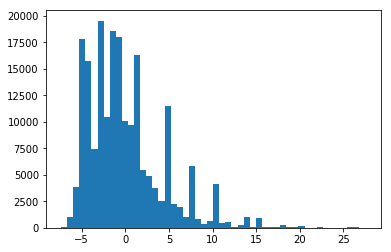

In [384]:
plt.hist(y_test-y_rf, bins=50)

In [408]:
regr2 = RandomForestRegressor(max_depth=5, random_state=137, n_estimators=2000)
regr2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
           oob_score=False, random_state=137, verbose=0, warm_start=False)

In [409]:
fimpDict2 = {}
for fimp in list(zip(XX.columns, regr2.feature_importances_)):
    print(fimp)
    fimpDict2.update({fimp[0]:fimp[1]})

('distance', 0.08411159554577159)
('surge_multiplier', 0.004798135772894215)
('temp', 4.058997336139654e-08)
('clouds', 1.3079708087929082e-07)
('pressure', 2.559713669665222e-07)
('rain', 5.058205400501373e-08)
('humidity', 4.494692498683774e-07)
('wind', 8.703892792528805e-08)
('name_Black', 0.10285456211881895)
('name_Black SUV', 0.30573628116164037)
('name_Lux', 0.055831286838348856)
('name_Lux Black', 0.12507198862350913)
('name_Lux Black XL', 0.32110437716214707)
('name_Lyft', 0.0)
('name_Lyft XL', 0.0)
('name_Shared', 0.0)
('name_Taxi', 0.0)
('name_UberPool', 0.0)
('name_UberX', 0.0)
('name_UberXL', 0.0)
('name_WAV', 0.0)
('destination_Back Bay', 0.00014439988558463074)
('destination_Beacon Hill', 1.8422604099186783e-10)
('destination_Boston University', 1.0964727054163061e-09)
('destination_Fenway', 9.071226103555381e-07)
('destination_Financial District', 6.982415602747525e-06)
('destination_Haymarket Square', 4.232965322789462e-05)
('destination_North End', 1.6964724484275228

In [410]:
kk = list(fimpDict.keys())
vv = list(fimpDict.values())


fimpDF = pd.DataFrame({'features':kk,
                      'importance':vv})

In [411]:
fimpDF.sort_values(by='importance')

,features,importance
22,destination_Beacon Hill,0.000000
23,destination_Boston University,0.000000
24,destination_Fenway,0.000000
25,destination_Financial District,0.000000
27,destination_North End,0.000000
28,destination_North Station,0.000000
30,destination_South Station,0.000000
31,destination_Theatre District,0.000000
43,source_Theatre District,0.000000
32,destination_West End,0.000000


## haven't run yet

In [3]:
merged_df = pd.read_csv('data/merged_df_Tues.csv')

In [254]:
merged_df = merged_df[(merged_df.price < 40) & (merged_df.price >5)]

In [351]:
X = merged_df.drop(['price', 'location', 'merge_date',
                    'lprice', 'distance', 'cab_type_Lyft', 'destination_Back Bay',
                    'source_Back Bay', 'name_Taxi'], axis=1)
X = sm.add_constant(X)
X.reset_index(drop=True,inplace=True)
Y = pd.DataFrame(norm_Y.T)
Y.reset_index(drop=True,inplace=True)


In [219]:
y_array = np.array(merged_df['price'])
norm_y = preprocessing.normalize([y_array])
merged_df['nnprice'] = pd.DataFrame(norm_y.T)

In [168]:
d_array = np.array(merged_df['distance'])
norm_d = preprocessing.normalize([d_array])
merged_df['ndistance'] = pd.DataFrame(norm_d.T)

In [169]:
t_array = np.array(merged_df['temp'])
norm_t = preprocessing.normalize([t_array])
merged_df['ntemp'] = pd.DataFrame(norm_t.T)

In [170]:
c_array = np.array(merged_df['clouds'])
norm_c = preprocessing.normalize([c_array])
merged_df['nclouds'] = pd.DataFrame(norm_c.T)

In [171]:
p_array = np.array(merged_df['pressure'])
norm_p = preprocessing.normalize([p_array])
merged_df['npressure'] = pd.DataFrame(norm_p.T)

In [172]:
r_array = np.array(merged_df['rain'])
norm_r = preprocessing.normalize([r_array])
merged_df['nrain'] = pd.DataFrame(norm_r.T)

In [173]:
h_array = np.array(merged_df['humidity'])
norm_h = preprocessing.normalize([h_array])
merged_df['nhumidity'] = pd.DataFrame(norm_h.T)

In [174]:
w_array = np.array(merged_df['wind'])
norm_w = preprocessing.normalize([w_array])
merged_df['nwind'] = pd.DataFrame(norm_w.T)

## Logistic Regression

In [191]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc

import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [133]:
X = merged_df[['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'cab_type_Uber', 'destination_Back Bay',
       'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL',
       'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_Taxi',
       'name_UberPool', 'name_UberX', 'name_UberXL', 'day_Fri',
       'day_Mon', 'day_Sat', 'day_Thu', 'day_Tue', 'day_Wed',
       'AMPM_PM', 'month_Dec', 'week_47', 'week_48',
       'week_49', 'sports', 'wkndPM']]
# X = sm.add_constant(X)
y = (merged_df.surge_multiplier != 1).astype(int)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=24)

In [135]:
#test_size = 0.2
print('Train:', X_train.shape, y_train.shape ,'\n', 'y1 train:', y_train.sum(),'\n',
       'Test:', X_test.shape, y_test.shape,'\n', 'y1 test:', y_test.sum())

Train: (508193, 55) (508193,) 
 y1 train: 16707 
 Test: (127049, 55) (127049,) 
 y1 test: 4177


In [136]:
#test_size = 0.5
print('Train:', X_train.shape, y_train.shape ,'\n', 'y1 train:', y_train.sum(),'\n',
       'Test:', X_test.shape, y_test.shape,'\n', 'y1 test:', y_test.sum())

Train: (508193, 55) (508193,) 
 y1 train: 16707 
 Test: (127049, 55) (127049,) 
 y1 test: 4177


In [137]:
mytrain = copy.deepcopy(X_train)
mytrain['y'] = y_train

In [138]:
Xy1 = mytrain[mytrain['y']==1]
Xy0 = mytrain[mytrain['y']==0]

In [139]:
print(Xy1.shape)
print(Xy0.shape)

(16707, 56)
(491486, 56)


In [165]:
lrp1 = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=3, max_iter=500, 
                             class_weight= 'balanced', n_jobs= -1)

In [181]:
lrp1a = LogisticRegressionCV(penalty='l1', solver='liblinear', n_jobs= -1)

In [166]:
features1 = ['ldistance','ltemp', 'clouds',
           'lpressure', 'rain', 'lhumidity', 'lwind',
           'cab_type_Uber', 'destination_Back Bay',
           'destination_Boston University',
           'destination_Fenway', 'destination_Financial District',
           'destination_Haymarket Square', 'destination_North End',
           'destination_North Station', 'destination_Northeastern University',
           'destination_South Station', 'destination_Theatre District',
           'destination_West End', 'source_Back Bay', 
           'source_Boston University', 'source_Fenway',
           'source_Financial District', 'source_Haymarket Square',
           'source_North End', 'source_North Station',
           'source_Northeastern University', 'source_South Station',
           'source_Theatre District', 'source_West End', 'name_Black',
           'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL',
           'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_Taxi',
           'name_UberPool', 'name_UberX', 'name_UberXL', 'day_Fri',
           'day_Mon', 'day_Sat', 'day_Thu', 'day_Tue', 'day_Wed',
           'AMPM_PM', 'month_Dec', 'week_47', 'week_48',
           'week_49', 'sports', 'wkndPM']

In [214]:
print(len(features1))
print(X.shape)

55
(635242, 55)


In [245]:
lrp1f1coef[2][0]

array([ 1.84172394e-02,  0.00000000e+00, -1.42202305e-01,  1.82945975e-01,
        0.00000000e+00,  2.59088260e-01, -2.53968899e-02, -7.63670195e+00,
        2.16824462e-01,  4.25882495e-02, -1.31619707e-02,  2.49284043e-03,
        0.00000000e+00,  1.62926275e-02, -1.59964100e-01,  0.00000000e+00,
        0.00000000e+00,  2.06121870e-01, -1.20199895e-01,  5.13933044e-01,
        2.44065176e-01,  3.37516428e-01, -3.86002755e-01, -1.60124443e+00,
       -1.67920374e+00, -7.08350206e-01,  4.35373992e-01, -4.06594622e-02,
        2.86094812e-01, -5.92718463e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.17632967e-02,  7.20070263e-02,
        1.43739142e-02, -5.79279312e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.88645974e-01,  0.00000000e+00,
        0.00000000e+00, -1.00024262e-01,  5.98574760e-02,  1.04598350e-01,
        0.00000000e+00, -4.04087595e-02,  0.00000000e+00, -1.60873729e-01,
        1.12790342e-01,  

In [246]:
lrp1f1coef[2]

array([[ 1.84172394e-02,  0.00000000e+00, -1.42202305e-01,
         1.82945975e-01,  0.00000000e+00,  2.59088260e-01,
        -2.53968899e-02, -7.63670195e+00,  2.16824462e-01,
         4.25882495e-02, -1.31619707e-02,  2.49284043e-03,
         0.00000000e+00,  1.62926275e-02, -1.59964100e-01,
         0.00000000e+00,  0.00000000e+00,  2.06121870e-01,
        -1.20199895e-01,  5.13933044e-01,  2.44065176e-01,
         3.37516428e-01, -3.86002755e-01, -1.60124443e+00,
        -1.67920374e+00, -7.08350206e-01,  4.35373992e-01,
        -4.06594622e-02,  2.86094812e-01, -5.92718463e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.17632967e-02,  7.20070263e-02,
         1.43739142e-02, -5.79279312e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.88645974e-01,  0.00000000e+00,  0.00000000e+00,
        -1.00024262e-01,  5.98574760e-02,  1.04598350e-01,
         0.00000000e+00, -4.04087595e-02,  0.00000000e+0

In [243]:
lrp1f1coef[1][0][0]

0.09665280138972615

In [220]:
lrclist = []
for c in range(0,len(lrp1f1coef)):
    lrc
lrcoefs = {}
for i in range(0,len(features1)):
    lrcoefs.update({features1[i]: lrp1f1coef[0][0][i]})
lrcoefs

{'ldistance': 0.09284656485686979,
 'ltemp': 0.0,
 'clouds': 0.04853521791349779,
 'lpressure': 0.13858825254838963,
 'rain': 0.0,
 'lhumidity': 0.0,
 'lwind': 0.0,
 'cab_type_Uber': -7.626153621661884,
 'destination_Back Bay': 0.014414486573924447,
 'destination_Boston University': 0.1569027741738351,
 'destination_Fenway': 0.0,
 'destination_Financial District': 0.15250009788304053,
 'destination_Haymarket Square': 0.07934678009176721,
 'destination_North End': 0.0,
 'destination_North Station': -0.012664435443730972,
 'destination_Northeastern University': -0.05509182241250888,
 'destination_South Station': 0.0,
 'destination_Theatre District': 0.2878439764626499,
 'destination_West End': -0.11745404437847337,
 'source_Back Bay': 0.24579310095522675,
 'source_Boston University': 0.1817820994676929,
 'source_Fenway': 0.04410448383883939,
 'source_Financial District': -0.21435510219318718,
 'source_Haymarket Square': -1.5813253764798267,
 'source_North End': -1.7806919118757676,
 'sou

In [249]:
def baglr(lr, features, n, nloop):
    lrcoeff = []
    lrscore = []
    lrpred = []
    for i in range(nloop):
        mySample1 = Xy1.sample(n, replace=True, random_state=i)
        mySample = mySample1.append(Xy0.sample(n, replace=True))
        mySample.reset_index(inplace=True, drop=True)
        y_sample = mySample['y']
        x_sample = mySample[features]
        lr.fit(x_sample, y_sample)
        print(lr.score(x_sample, y_sample), '\n', lr.coef_)
        lrscore.append(copy.deepcopy(lr.score(x_sample, y_sample)))
        lrcoeff.append(copy.deepcopy(lr.coef_))
        lrpred.append(copy.deepcopy(lr.predict(X_test)))
        probs = lr.predict_proba(X_test)
        preds = probs[:, 1]
        fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
        roc_auc = metrics.auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
#     print(lrcoeff,'\n', lrscore,'\n', lrpred)
    besti = lrscore.index(max(lrscore))
    lrcoefs = {}
    for i in range(0,len(features)):
        lrcoefs.update({features[i]: lrcoeff[besti][0][i]})
    return lrcoefs, lrscore, lrpred

0.82475 
 [[ 0.09284656  0.          0.04853522  0.13858825  0.          0.
   0.         -7.62615362  0.01441449  0.15690277  0.          0.1525001
   0.07934678  0.         -0.01266444 -0.05509182  0.          0.28784398
  -0.11745404  0.2457931   0.1817821   0.04410448 -0.2143551  -1.58132538
  -1.78069191 -0.89647866  0.10398204 -0.16140665  0.10944513 -0.88930932
   0.          0.          0.07317489  0.          0.0463388   0.
   0.         -5.65609839  0.          0.          0.          0.
  -0.06329333  0.          0.0551297   0.          0.09571144  0.
   0.          0.          0.11902177  0.11986197  0.02395963 -0.25054439
   0.14585639]]


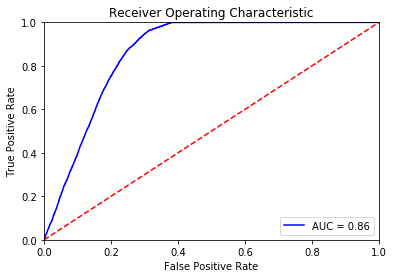

0.823375 
 [[ 9.66528014e-02  0.00000000e+00 -1.39258531e-02  1.18303052e-01
   0.00000000e+00  0.00000000e+00  5.60664757e-02 -7.58538667e+00
   0.00000000e+00 -8.57094530e-02 -1.84000236e-01  0.00000000e+00
   0.00000000e+00  9.62541554e-02  0.00000000e+00  1.37151634e-01
   0.00000000e+00  1.41030660e-01  1.10138514e-01  4.14109112e-01
   1.63382463e-01  0.00000000e+00 -2.80125462e-01 -1.49394266e+00
  -1.73569797e+00 -9.58156437e-01  2.49030254e-01 -2.39240146e-01
   1.54333339e-01 -9.45016837e-01  0.00000000e+00  0.00000000e+00
   1.45034704e-01  0.00000000e+00  5.06585699e-02  0.00000000e+00
   2.56395063e-02 -5.73802065e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.13016557e-02  0.00000000e+00
   6.23503487e-03  2.42861734e-01  1.68084263e-01  1.03190021e-01
   9.72025749e-02  0.00000000e+00  1.90095930e-02  6.44217345e-02
  -9.98745195e-02 -2.42403340e-01  3.17917468e-01]]


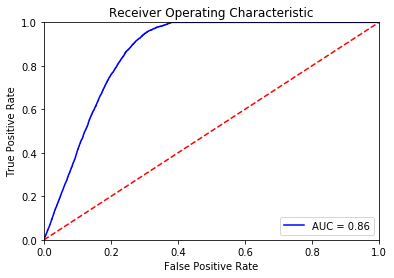

0.828125 
 [[ 1.84172394e-02  0.00000000e+00 -1.42202305e-01  1.82945975e-01
   0.00000000e+00  2.59088260e-01 -2.53968899e-02 -7.63670195e+00
   2.16824462e-01  4.25882495e-02 -1.31619707e-02  2.49284043e-03
   0.00000000e+00  1.62926275e-02 -1.59964100e-01  0.00000000e+00
   0.00000000e+00  2.06121870e-01 -1.20199895e-01  5.13933044e-01
   2.44065176e-01  3.37516428e-01 -3.86002755e-01 -1.60124443e+00
  -1.67920374e+00 -7.08350206e-01  4.35373992e-01 -4.06594622e-02
   2.86094812e-01 -5.92718463e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.17632967e-02  7.20070263e-02
   1.43739142e-02 -5.79279312e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.88645974e-01  0.00000000e+00
   0.00000000e+00 -1.00024262e-01  5.98574760e-02  1.04598350e-01
   0.00000000e+00 -4.04087595e-02  0.00000000e+00 -1.60873729e-01
   1.12790342e-01  0.00000000e+00  0.00000000e+00]]


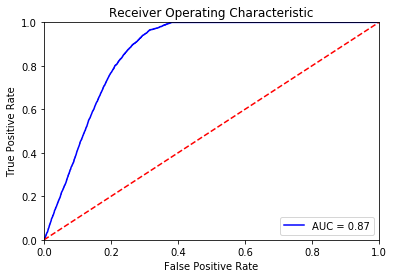

0.822125 
 [[ 1.01089742e-02  3.22946718e-01 -3.18529316e-01 -1.81316541e-03
  -1.40691150e+00 -3.45426662e-01 -9.34075756e-02 -1.32506819e+01
   1.16674542e-01  1.39331706e-02  6.48395670e-02  8.50628829e-02
  -1.58357349e-02  1.05793625e-01 -1.41312482e-01 -2.38236986e-01
  -1.26848285e-01  1.52102061e-01  2.57025783e-01  4.12677446e-01
   2.82651863e-01  3.08907161e-01 -1.03741218e-01 -1.55260270e+00
  -1.55645169e+00 -6.38380140e-01  3.59740072e-01 -1.32923889e-01
   7.58396314e-02 -6.34708029e-01  0.00000000e+00  0.00000000e+00
   5.03662467e-01  4.06548044e-01  5.05639363e-01  6.51237793e-01
   5.88460557e-01 -1.15135660e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.59053435e-01  5.53440090e-02
  -8.99298104e-02 -1.67523551e-01 -8.37295750e-02 -2.22257658e-01
  -2.60210495e-02 -1.94763709e-01 -1.20213440e-01 -1.95432493e-01
  -3.88628589e-02  5.81091496e-02  1.01019288e-01]]


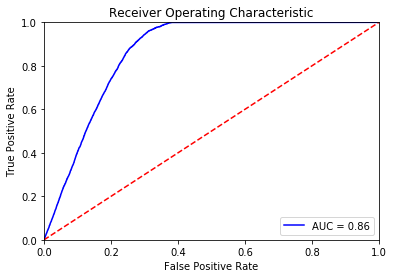

0.825875 
 [[-5.24086711e-02  5.93834940e-01 -1.51751117e-01 -1.78493135e-01
  -3.99650355e-01 -1.66667234e-01  2.15930169e-02 -1.16708890e+01
   1.49520689e-01 -6.91458046e-02  0.00000000e+00  1.55036736e-01
   8.24198101e-02  1.77963046e-01  1.74264405e-01 -2.92389139e-02
  -1.82360450e-01  1.10622475e-01  1.66784190e-01  4.60911917e-01
   2.07462512e-01  1.13559369e-01 -1.48039756e-01 -1.81717307e+00
  -2.10645071e+00 -8.80375688e-01  7.80974548e-02 -3.39344249e-01
   1.54867461e-01 -1.01813409e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -7.90855231e-02  1.68469918e-01  1.58128519e-01
   3.72597696e-02 -9.81211360e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.28648598e-03  1.02791802e-02
  -2.00035487e-01  2.86511861e-02  2.86570188e-02  9.24736186e-02
   2.07587959e-03  2.27179656e-01  1.65861525e-01 -1.52852861e-01
   1.62814908e-01 -7.43086850e-02 -3.91958761e-03]]


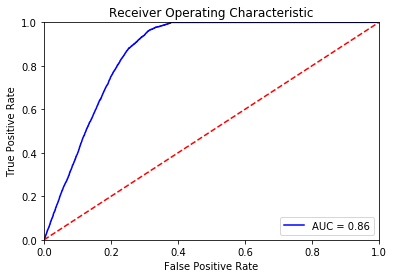

0.82175 
 [[ 9.29084505e-02  4.37102342e-01 -2.20736132e-01 -9.92744867e-02
  -2.49126627e-01  1.75272005e-02 -8.42458038e-02 -1.17590893e+01
   1.54797803e-01 -1.82754903e-02 -2.74726157e-02  1.98689750e-01
   0.00000000e+00  1.00385661e-01  1.22677035e-01  4.85355963e-02
  -1.15427635e-01  3.89610605e-01 -1.84077645e-01  6.20548213e-01
   1.29171812e-01  4.17004662e-01 -3.20384695e-01 -1.44765769e+00
  -1.67413424e+00 -8.86618393e-01  5.07701990e-01 -3.98620954e-01
   2.75458765e-01 -4.74330093e-01  0.00000000e+00  0.00000000e+00
   1.85926924e-02  0.00000000e+00 -8.10984243e-02  2.70972565e-02
   3.48660933e-02 -9.87562677e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.31673626e-01  1.06979453e-03
  -1.50820511e-01 -1.95617725e-01  2.20028213e-01  2.61133202e-01
   1.07699825e-01  2.45133037e-01  1.96284406e-01 -7.16969567e-03
   3.34797217e-01  7.65098350e-02 -1.75740374e-01]]


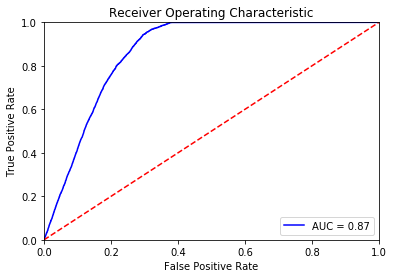

0.823375 
 [[ 0.12385563  0.          0.          0.13411051  0.          0.
   0.         -5.43563009  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.32627729  0.          0.05306173 -0.07482634 -1.20999368
  -1.27918449 -0.52944696  0.16020842  0.          0.         -0.36031523
   0.          0.          0.01684094  0.          0.          0.
   0.         -3.60084711  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        ]]


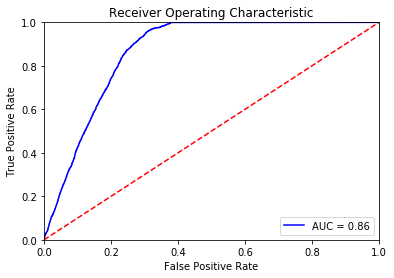

0.8235 
 [[ 2.89146192e-02  1.46764018e-01 -4.00097909e-01  1.14674026e-01
   0.00000000e+00  0.00000000e+00  4.12559076e-02 -7.59728948e+00
   0.00000000e+00  7.98901295e-02 -2.18232754e-02  0.00000000e+00
   4.08883937e-02  0.00000000e+00 -3.80355988e-02  1.24604828e-01
  -8.91942331e-02  4.74339995e-02 -1.17294381e-01  3.31905539e-01
   0.00000000e+00  2.11249204e-01 -4.65551376e-01 -1.50915316e+00
  -1.75456775e+00 -1.07046610e+00  4.04182930e-01 -2.38928810e-01
   0.00000000e+00 -7.95212158e-01  0.00000000e+00  0.00000000e+00
   6.24444039e-02  2.39055963e-02 -6.21991655e-03  0.00000000e+00
   5.74757263e-03 -5.86365253e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.59632759e-02  5.03797723e-02
   0.00000000e+00  1.81320898e-02 -4.62923265e-02 -6.97446988e-02
   5.82811440e-02  0.00000000e+00 -6.42115769e-02 -4.17439907e-03
   0.00000000e+00  2.67273764e-01 -1.15600626e-01]]


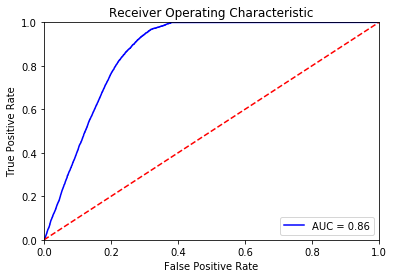

0.817375 
 [[ 1.61362350e-02  0.00000000e+00 -1.74962056e-01  1.75752345e-01
   0.00000000e+00  1.67873042e-01  0.00000000e+00 -7.56739019e+00
  -1.25787482e-01  7.12931071e-02 -2.43923858e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.40915740e-01 -1.34719390e-01
  -5.20829072e-02  1.16918506e-01  0.00000000e+00  2.89387864e-01
   1.54497967e-01  5.11977533e-01 -1.73645824e-01 -1.47961747e+00
  -1.42719251e+00 -7.99357777e-01  2.80299981e-01  0.00000000e+00
   3.87294637e-01 -8.39030076e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -8.20421486e-02  4.61716067e-02  8.65079481e-02
   2.10339870e-03 -5.65122901e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.10174370e-01  1.53634535e-02
  -6.05893261e-02  2.46554062e-02  0.00000000e+00 -1.32435299e-01
   0.00000000e+00  7.27335116e-02  0.00000000e+00 -4.47895422e-02
  -1.52208218e-01  0.00000000e+00  1.81568488e-02]]


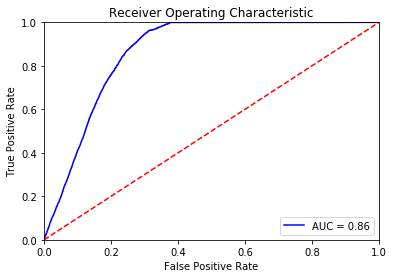

0.828875 
 [[ 0.00000000e+00  0.00000000e+00 -9.80599592e-02  1.81867517e-01
   0.00000000e+00 -8.86302742e-02  0.00000000e+00 -7.66537962e+00
   1.16241367e-01  0.00000000e+00  1.17706953e-01 -3.59650508e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.62326420e-01  0.00000000e+00  4.58838242e-02  2.22797555e-01
   5.44999513e-02  1.52688404e-01 -2.71014149e-01 -1.68164719e+00
  -1.74829300e+00 -8.33898330e-01  9.08450724e-02 -6.63853218e-02
   2.16179230e-01 -7.33570657e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.44180660e-03 -4.08128175e-02  3.32744864e-02
   4.56067321e-02 -5.74976764e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -9.34286281e-03 -1.17760872e-01
   9.27560378e-02  1.30729906e-02 -1.54504082e-01  0.00000000e+00
   1.22505450e-02  1.29911493e-01  0.00000000e+00 -1.25317845e-01
  -3.39955899e-01 -1.96661061e-01  2.17399519e-01]]


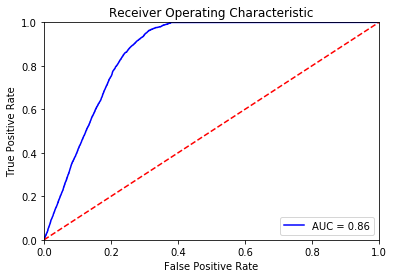

In [176]:
lrp1f1coef, lrp1f1score, lrp1f1pred = baglr(lrp1,features1)

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.83125 
 [[ 0.06120859  0.          0.          0.16457294  0.          0.
  -0.01527756 -7.66287945  0.          0.18712407 -0.21270532  0.0495777
   0.          0.02757133 -0.09115751  0.         -0.05108027  0.06933954
  -0.14542285  0.33361973  0.42691125  0.29564991 -0.15010209 -1.6422398
  -1.8379077  -0.91679223  0.32530295 -0.09125984  0.16421312 -0.87128656
   0.          0.          0.0685023   0.01651404  0.17877274  0.
  -0.00824236 -5.61262701  0.          0.          0.          0.
  -0.11298364 -0.0478306   0.         -0.19920224 -0.04202242  0.
  -0.01646264  0.07980695  0.         -0.26942246  0.         -0.08584308
   0.04372781]]


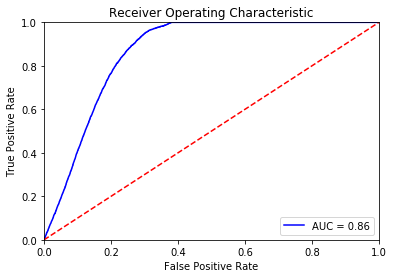

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.83075 
 [[ 1.76091624e-01 -1.14727683e-01 -3.92634530e-02  1.54244878e-01
   0.00000000e+00 -2.09643316e-01  2.46054595e-02 -9.74611364e+00
   1.64782201e-01 -1.51361160e-01  0.00000000e+00  1.80552375e-01
  -1.71202151e-01  0.00000000e+00 -1.49892099e-01  1.08259797e-01
  -2.73058635e-02  8.05691322e-02  4.66496421e-02  5.42507635e-01
   6.51102436e-02  1.33472973e-01 -8.05485889e-02 -1.31675648e+00
  -1.81113608e+00 -9.25267719e-01  1.92517110e-01  2.14252837e-03
   4.86736065e-01 -7.23866632e-01  0.00000000e+00  0.00000000e+00
  -9.37775306e-02  7.88975479e-02  6.20574849e-02  1.29902898e-02
   0.00000000e+00 -7.95575616e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.06609947e-02  1.14602602e-01
  -9.14640834e-02  8.29356078e-02 -2.17932255e-02  1.23604112e-01
   1.54617912e-02  1.19777764e-01  1.46972667e-01  1.81690836e-01
   7.62410930e-02 -2.84978433e-01  3.81818450e-01]]


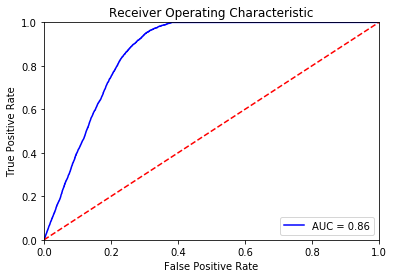

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.829625 
 [[ 7.20173626e-02  0.00000000e+00 -4.14235394e-03  1.22903930e-01
   0.00000000e+00 -1.23873001e-01  0.00000000e+00 -7.70693455e+00
   4.87032284e-02  0.00000000e+00 -2.21601979e-02 -6.66628657e-02
   0.00000000e+00 -8.19694924e-02 -1.73749891e-01 -9.34128498e-02
   0.00000000e+00  1.47422304e-01 -6.58800276e-02  4.44958801e-01
   3.24036570e-01  1.81023299e-01 -3.52903578e-01 -1.47364132e+00
  -1.58482359e+00 -8.90007743e-01  4.47130458e-01  2.91147570e-02
   9.99163266e-02 -5.19748527e-01  0.00000000e+00  0.00000000e+00
   1.46054578e-02  0.00000000e+00 -4.14735191e-02  0.00000000e+00
   0.00000000e+00 -5.92407980e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -6.56311453e-02  1.61894254e-01
   1.19434696e-01 -1.20106124e-01  6.87064951e-02  1.03298842e-01
   2.47767081e-02  5.62023424e-02  2.17937638e-01  5.40940763e-02
   0.00000000e+00 -3.51567211e-02  2.53091404e-02]]


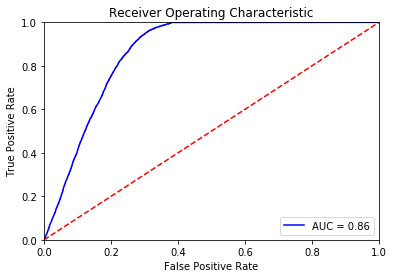

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.823625 
 [[ 1.16937798e-01  0.00000000e+00  9.14764733e-02  7.97938504e-02
   0.00000000e+00 -2.23526414e-01  7.66769425e-02 -7.55508270e+00
  -2.48390084e-02  0.00000000e+00  9.15071499e-02  3.54140635e-02
  -7.55608314e-02  2.73871378e-01 -1.66085069e-01 -1.48189308e-01
  -4.71471780e-02  8.12936893e-02  3.74159113e-02  6.46821695e-01
   1.67141371e-01  3.67038913e-01 -1.06849317e-01 -1.35109527e+00
  -1.39726525e+00 -8.25947512e-01  2.95692387e-01  0.00000000e+00
   2.56410959e-01 -8.18141110e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.36902903e-02  1.39998412e-01  2.33841602e-01
   1.78428403e-01 -5.65482427e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.43251835e-01  0.00000000e+00
   0.00000000e+00 -1.83226200e-01  0.00000000e+00 -1.87519334e-01
   1.17402240e-01  0.00000000e+00  2.54325161e-02  3.04768419e-02
   0.00000000e+00 -4.85552664e-02  3.83167887e-03]]


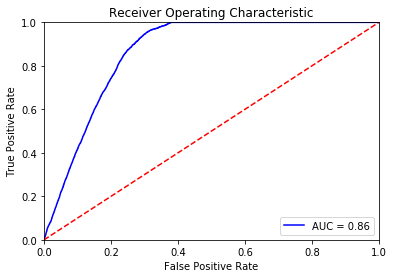

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.828 
 [[-3.18711004e-02  2.23288263e-01  1.11010280e-01 -8.51023728e-02
  -1.14982446e+00  2.22779279e-01 -5.24169194e-02 -1.27817140e+01
   3.56048339e-01  7.88684456e-02  3.09518385e-02  3.03086333e-01
   1.24300704e-01  9.79584847e-02  2.94879119e-01  1.15561883e-01
   1.77542861e-01  3.00680512e-01  1.96272078e-01  3.06205339e-01
  -1.23406391e-01 -7.57903863e-02 -3.87140036e-01 -1.98082309e+00
  -2.00324861e+00 -9.68676899e-01  1.00308284e-02 -5.38123059e-01
  -9.63567134e-02 -1.26010573e+00  0.00000000e+00  0.00000000e+00
   9.65729893e-01  1.03831749e+00  1.08857700e+00  1.13816682e+00
   1.03655114e+00 -1.09318379e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.76771577e-01  2.58687019e-01
   2.65823015e-01  3.08455081e-01  2.36142136e-01  1.48006085e-01
   6.59907652e-02 -9.62193687e-02 -1.79121603e-01  1.83589694e-02
  -1.05100912e-01 -2.76037287e-01  2.03856102e-01]]


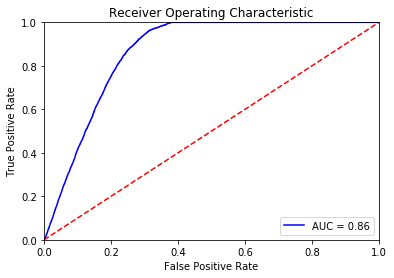

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8235 
 [[ 6.59378641e-02  9.49431480e-02 -4.35831082e-02  1.31718700e-01
   0.00000000e+00  0.00000000e+00 -1.48481685e-01 -7.56386660e+00
   1.21604099e-01  0.00000000e+00 -1.00717566e-01  1.59751349e-01
   1.32225003e-01  8.39089167e-03 -2.67532626e-02  0.00000000e+00
   1.37427572e-01  2.85108151e-02 -5.85201773e-02  3.18626068e-01
   0.00000000e+00  2.40375637e-01 -4.10747295e-01 -1.81027978e+00
  -1.58777477e+00 -8.41189068e-01  2.10102789e-01 -3.13013917e-01
   3.56945240e-02 -7.70119000e-01  0.00000000e+00  0.00000000e+00
  -2.59866503e-02  1.29409314e-01  1.28814676e-01  0.00000000e+00
   4.90663784e-02 -5.69467271e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -4.56492930e-02 -1.36402189e-01
  -1.49771344e-01 -1.46439244e-02  1.11860756e-01  0.00000000e+00
   1.92446139e-01  8.87850539e-02  0.00000000e+00  4.84657789e-02
   9.41484793e-02 -2.32103606e-03 -1.92531802e-01]]


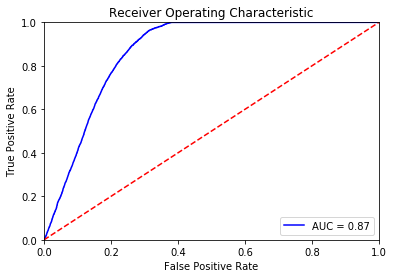

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.82825 
 [[ 5.04920061e-03  0.00000000e+00  0.00000000e+00  1.55593155e-01
   0.00000000e+00  7.36163999e-02 -1.67370767e-02 -7.60444294e+00
   6.57534981e-02  1.06047621e-01 -6.03535520e-02  1.46254520e-01
   5.64596105e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.04630358e-01 -9.51353892e-02  5.34221890e-01
   9.68289338e-02  8.47571304e-02 -2.83933811e-01 -1.67285093e+00
  -1.79250271e+00 -9.20701955e-01  3.24703396e-01 -2.22046668e-02
   8.92096723e-02 -8.24989243e-01  0.00000000e+00  0.00000000e+00
   1.52550016e-01  0.00000000e+00  1.06260065e-01  1.58616584e-01
   0.00000000e+00 -5.64176229e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.26872506e-01  7.23614930e-02
  -1.29760471e-02 -6.56115048e-02  1.01914294e-01  9.21440697e-02
  -4.03018290e-02  0.00000000e+00  1.35706512e-02  0.00000000e+00
   0.00000000e+00 -6.72662702e-02  2.06419653e-02]]


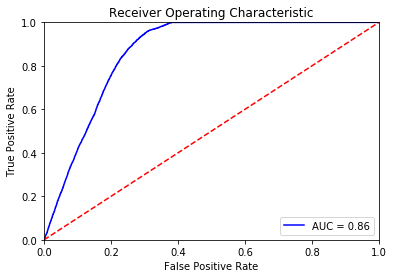

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.825875 
 [[-1.10260027e-01  7.76039928e-02 -3.38900125e-02  1.52308318e-01
  -1.10890433e+00 -9.82888771e-02 -5.45777695e-02 -9.65522299e+00
   2.42455997e-01  2.06082963e-01  5.02346663e-02  2.69034802e-01
   0.00000000e+00 -1.76945503e-01  1.46867356e-01  1.33025192e-01
  -9.85367768e-02  1.72712044e-01  9.06790445e-03  3.79436930e-01
   1.80493883e-01  1.53181311e-01 -5.20258652e-01 -1.97965461e+00
  -1.93898306e+00 -1.07838939e+00  1.29040287e-01 -4.68940440e-01
   2.71315295e-01 -8.79916498e-01  0.00000000e+00  0.00000000e+00
   5.87274759e-02  1.13327578e-01  3.50271357e-02  0.00000000e+00
  -7.21190050e-02 -7.91603723e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.22867169e-01 -3.47720167e-02
   1.37106566e-01 -1.40768777e-01  0.00000000e+00 -8.76915637e-02
   1.34919638e-01  6.43190051e-03 -6.68898397e-02 -3.71451895e-02
  -3.75779570e-02  3.30872952e-02 -2.72787265e-01]]


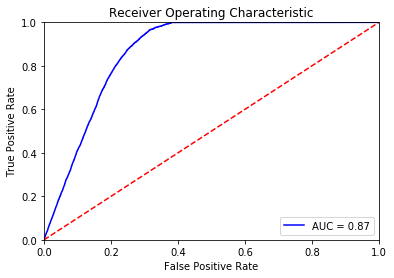

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.82575 
 [[-1.51043637e-02  0.00000000e+00 -3.78012378e-02  1.17371563e-01
   0.00000000e+00  0.00000000e+00  5.78616301e-02 -7.63696605e+00
  -1.44069426e-01  5.54894699e-02  6.48442061e-02  7.02531451e-02
  -9.21501763e-02  0.00000000e+00 -6.20541294e-02 -4.90824156e-02
   0.00000000e+00  0.00000000e+00  1.07218925e-01  4.05529453e-01
   3.22946852e-01  4.79563314e-01 -1.81906288e-01 -1.49693820e+00
  -1.47794065e+00 -8.46610388e-01  3.81085510e-01  0.00000000e+00
   2.89832548e-01 -8.49413418e-01  0.00000000e+00  0.00000000e+00
   2.82931618e-02 -1.68042927e-02  0.00000000e+00  0.00000000e+00
   1.40520945e-01 -5.77044920e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.29515326e-01
  -9.03708303e-02  9.20659339e-02 -5.61573407e-03 -3.89479579e-02
   2.82194770e-02  1.55725488e-01  0.00000000e+00 -1.11184508e-01
   8.36576738e-03  1.06779335e-01  0.00000000e+00]]


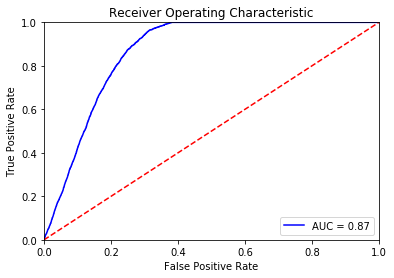

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.823375 
 [[ 0.00000000e+00 -1.67316840e-02 -2.01637367e-01  1.23717956e-01
   0.00000000e+00 -1.36416361e-02  9.00338983e-02 -7.57060324e+00
   6.05361607e-02  0.00000000e+00  1.01242892e-01  0.00000000e+00
   0.00000000e+00  4.75493846e-02  8.95424741e-02 -1.43752620e-01
  -2.18250715e-01  6.79867325e-02 -2.62376335e-04  2.05947096e-01
   9.41900646e-04  9.44672927e-02 -3.52825381e-01 -1.72826964e+00
  -1.69598626e+00 -7.54518741e-01  9.38472173e-02 -1.63215236e-01
   2.62990117e-01 -7.38969994e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.49369947e-01  8.56124996e-02  4.80513568e-02
  -2.71242119e-03 -5.70811197e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.87027722e-02  1.19702888e-01
   0.00000000e+00  1.08278227e-01 -4.70212073e-02  0.00000000e+00
  -9.94968807e-02  2.40615211e-01  2.77335331e-01  1.69303849e-01
  -8.95785884e-04 -3.14813820e-02  1.79819585e-01]]


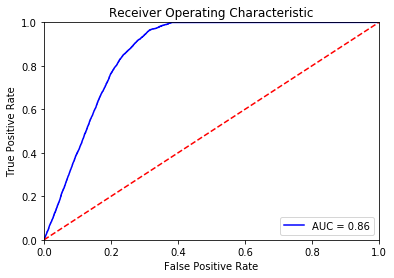

In [182]:
lrp1af1coef, lrp1af1score, lrp1af1pred = baglr(lrp1a,features1)

In [251]:
lrp1af1score

[0.915, 0.82, 0.775]

In [252]:
lrp1af1coef

{'ldistance': 0.5707152520668571,
 'ltemp': 0.0,
 'clouds': 0.0,
 'lpressure': 0.2936182591862294,
 'rain': 0.0,
 'lhumidity': 1.7829302467365802,
 'lwind': -0.5752347013879299,
 'cab_type_Uber': -7.350578769083887,
 'destination_Back Bay': 0.8440749150032404,
 'destination_Boston University': 0.0,
 'destination_Fenway': 1.0845608469324726,
 'destination_Financial District': 0.0,
 'destination_Haymarket Square': 2.705701300066176,
 'destination_North End': 0.0,
 'destination_North Station': 0.0,
 'destination_Northeastern University': 1.027250724902477,
 'destination_South Station': 0.0,
 'destination_Theatre District': 0.0,
 'destination_West End': -0.6544660525549219,
 'source_Back Bay': 0.35142062332741947,
 'source_Boston University': 0.0,
 'source_Fenway': -0.8306570173156217,
 'source_Financial District': 0.0,
 'source_Haymarket Square': -3.174816629756926,
 'source_North End': 0.0,
 'source_North Station': 0.0,
 'source_Northeastern University': 1.3043649538746909,
 'source_Sout

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.915 
 [[ 0.57071525  0.          0.          0.29361826  0.          1.78293025
  -0.5752347  -7.35057877  0.84407492  0.          1.08456085  0.
   2.7057013   0.          0.          1.02725072  0.          0.
  -0.65446605  0.35142062  0.         -0.83065702  0.         -3.17481663
   0.          0.          1.30436495 -0.06335166 -0.07157881 -4.08929965
   0.          0.          0.52393066  0.          0.44926258 -0.19171071
   0.         -5.29094453  0.          0.          0.          0.
  -0.2740614  -0.73942587 -0.20656505  0.17695746  0.         -0.23281471
   1.03580572  0.67232158  0.          0.         -0.09944142  0.96813174
  -2.27381453]]


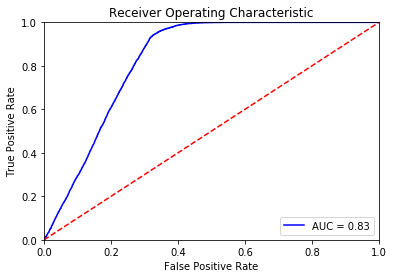

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.82 
 [[ 0.          0.          0.          0.08554087  0.          0.
   0.         -3.44873361  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.38994541  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.4152094   0.          0.
   0.46364685 -1.86229136  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.22716317 -0.17267225  0.
   0.        ]]


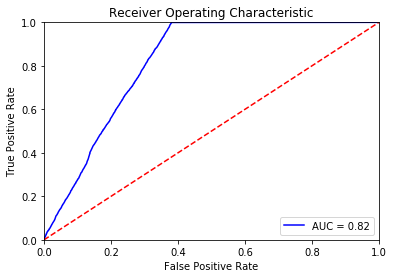

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.775 
 [[ 0.          0.          0.          0.11542734  0.          0.
  -0.18986973 -3.36032411  0.          0.          0.          0.
   0.          0.         -0.15527401  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.2624758   0.          0.27722729
   0.         -0.62064196  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.11418188  0.          0.          0.          0.
   0.        ]]


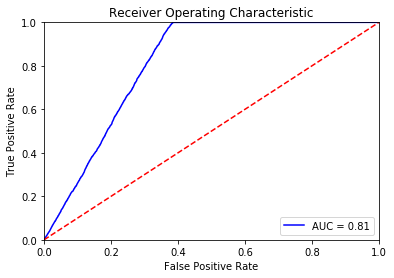

In [250]:
lrp1af1coef, lrp1af1score, lrp1af1pred = baglr(lrp1a,features1,100,3)

In [230]:
lrp1af1coef

{'ldistance': 0.40613415135543784,
 'ltemp': 0.0,
 'clouds': 0.0,
 'lpressure': 0.057944835219041244,
 'rain': 0.0,
 'lhumidity': 0.0,
 'lwind': 0.0,
 'cab_type_Uber': -3.490435769827449,
 'destination_Back Bay': 0.0,
 'destination_Boston University': 0.0,
 'destination_Fenway': 0.0,
 'destination_Financial District': 0.0,
 'destination_Haymarket Square': 0.0,
 'destination_North End': 0.0,
 'destination_North Station': 0.0,
 'destination_Northeastern University': 0.0,
 'destination_South Station': 0.0,
 'destination_Theatre District': 0.0,
 'destination_West End': 0.0,
 'source_Back Bay': 0.0,
 'source_Boston University': 0.0,
 'source_Fenway': 0.0,
 'source_Financial District': 0.0,
 'source_Haymarket Square': 0.0,
 'source_North End': -0.12512527888879332,
 'source_North Station': 0.0,
 'source_Northeastern University': 0.1974959040642896,
 'source_South Station': 0.0,
 'source_Theatre District': 0.0,
 'source_West End': -0.3002966240049584,
 'name_Black': 0.0,
 'name_Black SUV': 0.

0.8246 
 [[ 7.71411312e-02  0.00000000e+00  4.88985481e-03  1.66935587e-01
   0.00000000e+00  1.32989136e-01  0.00000000e+00 -7.80985926e+00
   7.63811324e-02  0.00000000e+00  5.54932680e-02  0.00000000e+00
  -1.21537420e-01  0.00000000e+00  0.00000000e+00 -2.38789711e-01
   1.17418818e-02  4.68003207e-02  3.15626369e-02  2.58755107e-01
   6.61899440e-02  8.72115163e-02 -2.74052262e-01 -1.42950815e+00
  -1.92031111e+00 -8.80636281e-01  2.67537373e-01 -1.59691411e-01
   1.32308876e-01 -7.61574857e-01  0.00000000e+00  0.00000000e+00
   2.34067779e-02  8.54082622e-02  4.68628524e-02 -2.32977725e-03
   0.00000000e+00 -5.99109021e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.99010514e-02 -5.81070145e-02
   0.00000000e+00  4.64597860e-03  0.00000000e+00  0.00000000e+00
   2.22742635e-03  0.00000000e+00  9.22700376e-03 -7.72316995e-02
   1.96850263e-02  0.00000000e+00 -1.17377978e-02]]


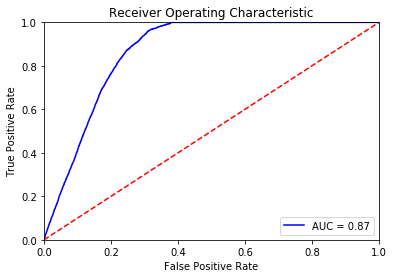

0.8229 
 [[ 6.16143409e-02  0.00000000e+00 -8.43980215e-02  1.33455636e-01
   0.00000000e+00  0.00000000e+00  1.96575685e-02 -7.79671396e+00
   0.00000000e+00  1.56157196e-01 -7.07319629e-02 -1.21307922e-02
  -1.02374795e-01  7.35914346e-04 -8.65486390e-02  0.00000000e+00
   0.00000000e+00  4.34830770e-02  3.10203160e-02  5.40162767e-01
   1.88800200e-01  2.96810887e-01 -1.70809282e-01 -1.51518848e+00
  -1.68487891e+00 -8.53969842e-01  1.21090892e-01 -6.58583698e-02
   2.67107603e-01 -7.56456908e-01  0.00000000e+00  0.00000000e+00
   4.57071724e-02  0.00000000e+00  0.00000000e+00  3.58694583e-02
   0.00000000e+00 -5.98367927e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.43242022e-01  1.03743184e-01
   0.00000000e+00  6.09424184e-02 -6.97635035e-02  0.00000000e+00
   1.21199059e-01  5.63198051e-02  0.00000000e+00 -5.90707882e-03
  -7.18735531e-02 -1.77574887e-01  1.84020122e-01]]


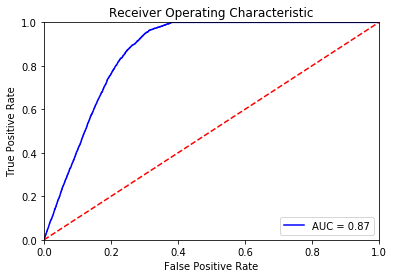

0.824 
 [[ 0.07620834 -0.08913268 -0.19055587  0.21612288  0.          0.25644113
  -0.01831884 -9.91641452  0.06613781  0.         -0.06804545 -0.03399814
  -0.06486971  0.12858431  0.14375815  0.08493011  0.19924073  0.29351467
  -0.20039401  0.38500438  0.11148873  0.18711291 -0.36523859 -1.49674809
  -1.81977779 -0.92341104  0.23528961 -0.11174132  0.08880805 -0.66865092
   0.          0.          0.03052554 -0.14189668  0.08821026  0.11210427
   0.         -7.98062248  0.          0.          0.          0.
  -0.0642279   0.29090189  0.         -0.06064487  0.19769011  0.12798873
  -0.03866159  0.02494278  0.06465809 -0.22556494 -0.07169931 -0.13981495
   0.35788603]]


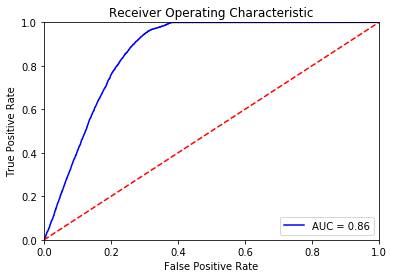

0.8226 
 [[  0.01735569  -0.31180113  -0.06469358   0.21965768  -1.18725061
   -0.11331831   0.02955987 -11.9489168   -0.06938377   0.14581173
    0.24753255   0.0643749   -0.25261333   0.13093785   0.15283471
   -0.20116922   0.           0.02461669  -0.19693551   0.47190524
    0.35663939   0.37450781  -0.41704315  -1.66515845  -1.41357964
   -0.90543387   0.3757274   -0.08427471   0.4140047   -0.767544
    0.           0.           0.07099123   0.           0.0176086
   -0.01766974   0.02594036 -10.08490715   0.           0.
    0.           0.          -0.24796202   0.06930707  -0.09317468
   -0.15925148   0.12089161  -0.14162791   0.04463043  -0.11979424
   -0.03040252   0.08538124   0.13711384   0.19617762   0.07912228]]


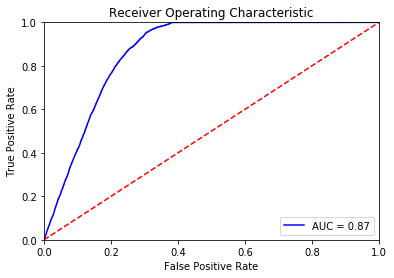

0.8217 
 [[ 2.63501833e-02  2.39468539e-01 -9.46428398e-02  0.00000000e+00
   0.00000000e+00  8.30680388e-02  3.26708148e-02 -7.81747717e+00
   1.34217091e-02  0.00000000e+00  1.49890594e-01  1.27519665e-01
   0.00000000e+00 -2.00975853e-03  0.00000000e+00  0.00000000e+00
  -2.72745496e-02  8.50558138e-02 -2.20911629e-02  5.72980324e-01
   3.09065901e-01  4.06405293e-01 -2.24687050e-01 -1.45837650e+00
  -1.50376484e+00 -6.66414358e-01  4.52041538e-01 -8.10723836e-02
   3.46939246e-01 -6.34924533e-01  0.00000000e+00  0.00000000e+00
   9.76975522e-02 -5.55503916e-02  0.00000000e+00  2.11538253e-02
   0.00000000e+00 -5.90879788e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  4.06551392e-02
   0.00000000e+00  3.62974288e-03  0.00000000e+00  0.00000000e+00
   1.23347611e-01  8.22679856e-02  0.00000000e+00 -1.00096775e-01
   3.19132894e-02 -1.54265525e-01 -2.58263809e-02]]


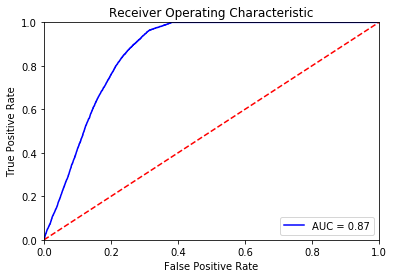

0.8189 
 [[ 8.13176508e-02  0.00000000e+00  0.00000000e+00  1.20918711e-01
   0.00000000e+00  0.00000000e+00  2.28897602e-02 -7.73095766e+00
   1.64121325e-01  1.05389596e-01 -1.27631301e-01  1.60093034e-01
   1.39740249e-01  1.86003080e-02  0.00000000e+00 -1.25482625e-02
   0.00000000e+00  7.76538805e-02  1.30552676e-03  2.60426556e-01
   2.23014968e-02  0.00000000e+00 -3.22386202e-01 -1.65820217e+00
  -1.68925076e+00 -8.97605897e-01  9.40890264e-02 -4.38554725e-01
   9.69067107e-02 -8.58997454e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  9.80784889e-02  1.48833474e-01
   1.14053052e-01 -5.93245311e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.01410380e-02  0.00000000e+00
   2.29147686e-02  0.00000000e+00  5.21563334e-02 -5.31579316e-02
   2.86890559e-02  1.19719802e-01  1.89299783e-01  7.41297879e-02
   0.00000000e+00  0.00000000e+00 -5.08550954e-02]]


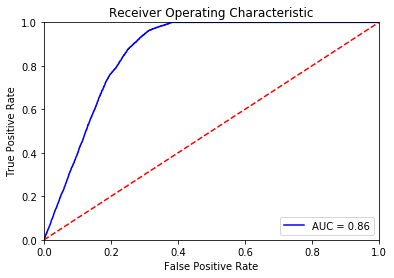

0.8253 
 [[ 6.38805232e-02  0.00000000e+00  0.00000000e+00  1.57613387e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.82548932e+00
   6.08989548e-02  0.00000000e+00 -2.15144261e-02 -5.10577067e-02
   0.00000000e+00  0.00000000e+00 -8.56495750e-02 -1.11394114e-02
   2.57930818e-02 -8.22621247e-02  0.00000000e+00  2.59374623e-01
   1.79577807e-02  2.29606330e-01 -2.90312558e-01 -1.77401839e+00
  -1.74257071e+00 -9.21341219e-01  3.04898326e-01 -1.94072195e-01
   2.21975162e-02 -8.06174739e-01  0.00000000e+00  0.00000000e+00
   3.94905976e-02  9.01607060e-02 -1.25116017e-01  0.00000000e+00
   2.60137736e-02 -6.01517052e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.23990255e-02  9.61464160e-02
   0.00000000e+00 -1.78912613e-02  1.48553704e-01  2.11007803e-01
  -1.25474128e-01  0.00000000e+00  7.52488685e-03  2.86822444e-02
   9.30211090e-02  1.83437407e-02  7.75979080e-02]]


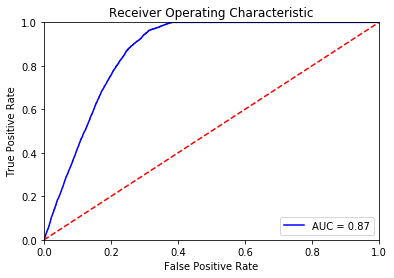

0.8245 
 [[ 1.06902355e-01  0.00000000e+00 -1.91988541e-01  1.69424610e-01
   0.00000000e+00 -5.24204083e-02  4.90630325e-02 -7.83236741e+00
   7.29164358e-02  7.05811762e-03  0.00000000e+00 -1.10822619e-01
   0.00000000e+00  0.00000000e+00  3.75238216e-02  6.32408017e-02
  -2.68105222e-03  9.97180503e-02  1.31513629e-01  2.14607151e-01
   0.00000000e+00  7.18753917e-02 -5.26949060e-01 -1.68773907e+00
  -1.87981427e+00 -1.05397390e+00  2.44621316e-01 -3.46159788e-01
   5.17180319e-02 -8.75082294e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.86466145e-02  1.13090604e-01  0.00000000e+00
   3.78188709e-02 -6.01595795e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -9.29366033e-03  0.00000000e+00
   7.42407762e-02 -4.62394736e-02  0.00000000e+00  5.41717889e-02
   2.40243353e-02  3.15448261e-02 -2.14952539e-02 -1.73832415e-02
  -1.86448033e-01  0.00000000e+00  7.25500318e-03]]


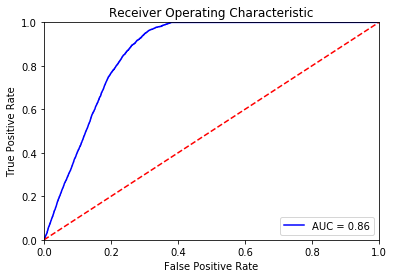

0.8278 
 [[ 7.17215645e-03  0.00000000e+00 -6.31963311e-03  1.40183040e-01
   0.00000000e+00  0.00000000e+00  2.63521225e-03 -7.78868619e+00
   0.00000000e+00  0.00000000e+00 -1.28473432e-01  2.08297152e-01
   0.00000000e+00  3.26659085e-02 -7.99831359e-02  0.00000000e+00
  -3.08367087e-01  1.24890887e-01  0.00000000e+00  4.73051937e-01
   9.99242985e-02  2.35714356e-01 -2.13364144e-01 -1.74064954e+00
  -1.62199290e+00 -8.63987419e-01  3.48815725e-01 -2.42212816e-01
   2.71947148e-01 -6.25373583e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  6.36427442e-02  2.32271352e-01
   1.43136005e-01 -5.98156532e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.28300693e-02  1.08275885e-01
  -1.05972430e-01  0.00000000e+00 -1.60012720e-03  6.27384238e-02
   8.68454013e-02  4.29026773e-02  0.00000000e+00 -1.28500643e-01
   0.00000000e+00  0.00000000e+00  5.43189365e-02]]


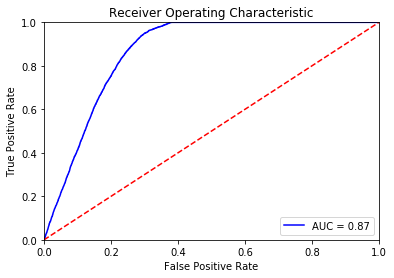

0.8289 
 [[ 0.09049348  0.21844112 -0.28309718  0.07315294  0.52621801  0.05013421
   0.03169585 -9.95490457  0.09828688 -0.06850692  0.04183221  0.06117577
   0.15102752  0.05807498 -0.1176599  -0.06180747  0.          0.10048886
   0.08269908  0.23442503  0.29995334  0.02512944 -0.36938821 -1.74918743
  -1.8648657  -1.04365529  0.26310784 -0.32470979  0.11913845 -0.75994121
   0.          0.          0.          0.05769882  0.07529025  0.01666233
  -0.05602929 -7.98424575  0.          0.          0.          0.
   0.01169737 -0.10846882  0.05195871 -0.27280055 -0.12825996 -0.02514284
   0.03254042  0.06687107  0.01556212  0.04523442 -0.11426914  0.15113125
  -0.1674974 ]]


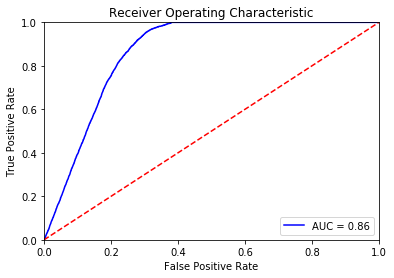

In [184]:
lrp1f15kcoef, lrp1f15kscore, lrp1f15kpred = baglr(lrp1,features1,5000)

In [177]:
lrp1f1coef

[array([[ 0.09284656,  0.        ,  0.04853522,  0.13858825,  0.        ,
          0.        ,  0.        , -7.62615362,  0.01441449,  0.15690277,
          0.        ,  0.1525001 ,  0.07934678,  0.        , -0.01266444,
         -0.05509182,  0.        ,  0.28784398, -0.11745404,  0.2457931 ,
          0.1817821 ,  0.04410448, -0.2143551 , -1.58132538, -1.78069191,
         -0.89647866,  0.10398204, -0.16140665,  0.10944513, -0.88930932,
          0.        ,  0.        ,  0.07317489,  0.        ,  0.0463388 ,
          0.        ,  0.        , -5.65609839,  0.        ,  0.        ,
          0.        ,  0.        , -0.06329333,  0.        ,  0.0551297 ,
          0.        ,  0.09571144,  0.        ,  0.        ,  0.        ,
          0.11902177,  0.11986197,  0.02395963, -0.25054439,  0.14585639]]),
 array([[ 9.66528014e-02,  0.00000000e+00, -1.39258531e-02,
          1.18303052e-01,  0.00000000e+00,  0.00000000e+00,
          5.60664757e-02, -7.58538667e+00,  0.00000000e+00,
   

In [178]:
lrp1f1score

[0.82475,
 0.823375,
 0.828125,
 0.822125,
 0.825875,
 0.82175,
 0.823375,
 0.8235,
 0.817375,
 0.828875]

In [185]:
lrp1af1score

[0.83125,
 0.83075,
 0.829625,
 0.823625,
 0.828,
 0.8235,
 0.82825,
 0.825875,
 0.82575,
 0.823375]

In [187]:
lrp1f15kscore

[0.8246, 0.8229, 0.824, 0.8226, 0.8217, 0.8189, 0.8253, 0.8245, 0.8278, 0.8289]

In [189]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

Using TensorFlow backend.


In [ ]:
X_train_lr, y_train_lr = make_classification(
weights=[(1-0.03182891979424652),0.03182891979424652], n_samples=508193, random_state=10)
print('Original dataset shape %s' % Counter(y_train_lr))
#Original dataset shape Counter({1: 900, 0: 100})
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_lr, y_train_lr)
print('Resampled dataset shape %s' % Counter(y_res))
#Resampled dataset shape Counter({0: 900, 1: 900})

1    491486
0    491486
dtype: int64


/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for smote: 0.8644617410414723


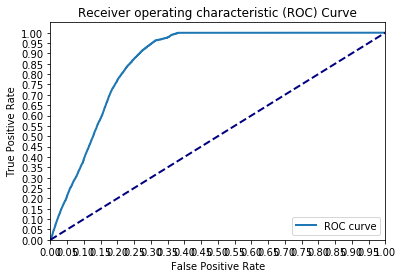

In [194]:
smote = SMOTE(sampling_strategy=1)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
print(pd.Series(y_train_resampled).value_counts()) #Preview synthetic sample class distribution
logreg = LogisticRegression(fit_intercept = False, C = 1e12,solver ='lbfgs') #Starter code
model_log = logreg.fit(X_train_resampled, y_train_resampled)
print(model_log) #Preview model params

#Predict
y_hat_test = logreg.predict(X_test)

y_score = logreg.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print('AUC for smote: {}'.format(auc(fpr, tpr)))
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [195]:
logreg.coef_

array([[-2.10032410e-02, -7.44569755e-02, -5.62632681e-02,
        -3.72924231e-01, -7.71902452e-01,  2.01912803e-01,
         3.50708692e-02, -1.16997158e+01, -2.19567086e-01,
         3.80563370e-01,  3.46874286e-01, -1.64939929e-01,
         3.04331614e-01,  3.26936135e-01, -2.82031157e-01,
         3.42715971e-01,  2.48386330e-01, -1.47508108e-01,
        -2.62868482e-01,  2.64412291e-02,  4.10561436e-01,
         4.69010044e-01, -7.60727868e-01, -1.62508902e+00,
        -1.70737804e+00, -1.45114939e+00,  4.80742693e-01,
        -6.14817137e-03, -1.24291426e-01, -1.27364919e+00,
        -1.92711788e+00, -1.92194978e+00,  3.91832718e+00,
         3.87950314e+00,  3.89406444e+00,  3.90412602e+00,
         3.89365691e+00, -7.81845527e+00,  0.00000000e+00,
        -1.92273548e+00, -1.91565891e+00, -1.92519800e+00,
         9.95769072e-02,  6.59026939e-02,  2.95129545e-02,
         1.25014975e-01,  7.26457386e-02,  5.24276104e-02,
         9.10128264e-02,  7.71025126e-02,  2.09098890e-0

In [4]:
lr_l2 = LogisticRegressionCV(penalty='l2', cv=3, max_iter=500 , class_weight= 'balanced' , n_jobs= -1)

In [ ]:
lr_11_rs = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=3, max_iter=500, class_weight= 'balanced' , n_jobs= -1)
lr_l2_rs = LogisticRegressionCV(penalty='l2', cv=3, max_iter=500 , class_weight= 'balanced', n_jobs= -1)


In [11]:
lr_11.fit(X_train_lr, y_train_lr)

KeyboardInterrupt: 

In [ ]:
lr_l2.fit(X_train_lr, y_train_lr)

In [ ]:
lr_11_rs.fit(X_train_resampled, y_train_resampled)
lr_l2_rs.fit(X_train_resampled, y_train_resampled)

In [734]:
lr_11.score(X_test_lr, y_test_lr)

0.9669497595415942

In [735]:
lr_l2.score(X_test_lr, y_test_lr)

0.9669497595415942

In [700]:
lr.score(X_test_lr, y_test_lr)

0.6953458901683602

In [736]:
lr_11.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.47658586,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [737]:
lr_l2.coef_

array([[ 6.57497891e-06,  9.91397861e-02, -2.50726651e-03,
        -5.91179142e-03, -1.69183828e-04, -8.31323335e-05,
        -6.64493502e-04, -2.86904818e-03, -5.71125357e-01,
        -9.46557961e-04,  3.12362823e-03, -4.33959255e-04,
        -1.88004896e-04,  3.02287408e-03,  9.90129386e-03,
        -4.50692303e-03, -1.48351527e-03,  3.14193126e-03,
         4.12554873e-03, -7.98281016e-03,  7.72564059e-02,
         4.62543718e-02,  5.69117129e-02, -2.19920906e-02,
        -8.67427668e-02, -9.22427980e-02, -6.06410550e-02,
         6.12306464e-02, -2.67684418e-03,  5.20068397e-02,
        -5.26775613e-02, -9.35830333e-02, -9.34743913e-02,
         1.44540314e-01,  1.45255646e-01,  1.43779762e-01,
         1.44621713e-01,  1.37556794e-01, -1.44622297e-01,
         0.00000000e+00, -9.37887867e-02, -9.36516994e-02,
        -9.37445277e-02, -1.42302035e-04,  1.32794551e-03,
        -8.60977647e-04,  2.61885809e-05,  1.02514215e-03,
         9.30670547e-04,  5.83675302e-03, -2.27577721e-0

In [ ]:
lr_11.score(X_test_lr, y_test_lr)

In [ ]:
lr_l2.score(X_test_lr, y_test_lr)

In [ ]:
lrl1_predict = lr_11.predict(X_test_lr)

In [ ]:
lrl2_predict = lr_l2.predict(X_test_lr)

In [ ]:
pred_comp_df = pd.DataFrame([lrl1_predict, lrl2_predict]).T

In [ ]:
pred_comp_df[0].value_counts()

In [ ]:
pred_comp_df[1].value_counts()

In [730]:
lr = LogisticRegressionCV(cv=3, max_iter=500)


In [ ]:
lr.score(X_test_lr, y_test_lr)

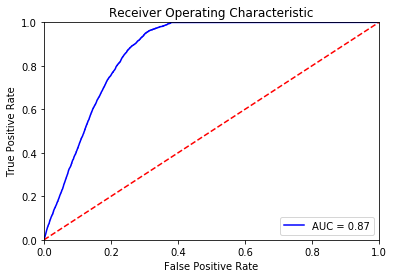

In [703]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test_lr)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_lr, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

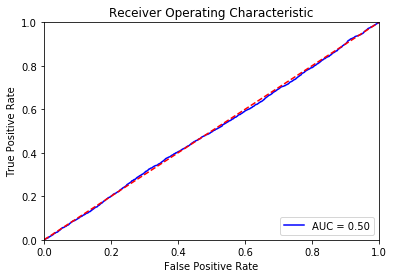

In [724]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = lr_11.predict_proba(X_test_lr)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_lr, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

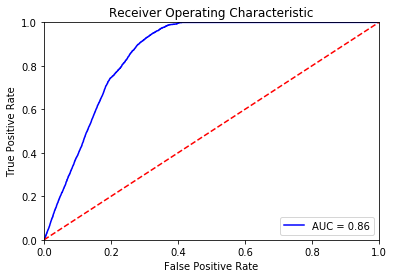

In [725]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = lr_l2.predict_proba(X_test_lr)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_lr, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [696]:
probs[:5]

array([[9.81101186e-01, 1.88988140e-02],
       [9.99996468e-01, 3.53182217e-06],
       [8.73379625e-01, 1.26620375e-01],
       [9.99958615e-01, 4.13851251e-05],
       [8.63060976e-01, 1.36939024e-01]])